# Time Series Models - Arima & Prophet

### Importing / Installing packages

In [1]:
# Packages / libraries
import os #provides functions for interacting with the operating system
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

# To install sklearn type "pip install numpy scipy scikit-learn" to the anaconda terminal

# To change scientific numbers to float
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

# Increases the size of sns plots
sns.set(rc={'figure.figsize':(8,6)})

#ARIMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

import pmdarima as pm
from pmdarima.model_selection import train_test_split

from prophet import Prophet

from pandas import to_datetime

import itertools
import warnings

import datetime
from datetime import datetime
warnings.filterwarnings('ignore')

# installing auto arima
# pip install --user pmdarima

# installing fbprophet
# pip install --user fbprophet
# !pip install --upgrade plotly

### Reading / Loading the Raw Data into Python From CSV

In [2]:
# Loading the data
raw_data = pd.read_csv('C:\gdp_data_raw.csv', encoding='latin-1')

# print the shape
print(raw_data.shape)

#runs the first 5 rows
raw_data.head()

(270039, 8)


,DEMO_IND,Indicator,LOCATION,COUNTRY,TIME,VALUES,Flag Codes,Flag
0,SP_DYN_TFRT_IN,"Fertility rate, total (births per woman)",AUS,Australia,1970.0,2.86,NaN,NaN
1,SP_DYN_TFRT_IN,"Fertility rate, total (births per woman)",AUS,Australia,1971.0,2.96,NaN,NaN
2,SP_DYN_TFRT_IN,"Fertility rate, total (births per woman)",AUS,Australia,1972.0,2.74,NaN,NaN
3,SP_DYN_TFRT_IN,"Fertility rate, total (births per woman)",AUS,Australia,1973.0,2.49,NaN,NaN
4,SP_DYN_TFRT_IN,"Fertility rate, total (births per woman)",AUS,Australia,1974.0,2.40,NaN,NaN


### Data Pre-Processing Phase

In [3]:
# Checking for null values
raw_data.isnull().sum()

DEMO_IND           0
Indicator          1
LOCATION           1
COUNTRY            1
TIME               1
VALUES          2067
Flag Codes    267973
Flag          267973
dtype: int64

In [4]:
raw_data['Indicator'][raw_data['VALUES'].isnull()].unique()

array(['Population growth (annual %)',
       'Rural population (% of total population)',
       'GDP deflator (base year varies by country)',
       'GDP growth (annual %)',
       'Poverty headcount ratio at $1.90 a day (PPP) (% of population)',
       'PPP conversion factor, GDP (LCU per international $)',
       'Total debt service (% of GNI)', 'GNI per capita (current LCU)',
       'Official exchange rate (LCU per US$, period average)',
       'GDP per capita (current LCU)',
       'PPP conversion factor, private consumption (LCU per international $)',
       'DEC alternative conversion factor (LCU per US$)', nan],
      dtype=object)

In [5]:
# Deleting the NULL values
raw_data = raw_data.dropna(subset = ['VALUES'])

# filtering out the last 2 columns
raw_data = raw_data[['DEMO_IND','Indicator','LOCATION','COUNTRY','TIME','VALUES']]

# Checking for null values
raw_data.isnull().sum()

DEMO_IND     0
Indicator    0
LOCATION     0
COUNTRY      0
TIME         0
VALUES       0
dtype: int64

In [6]:
# Investigate all the elements whithin each Feature 

for column in raw_data:
    unique_vals = np.unique(raw_data[column])
    nr_values = len(unique_vals)
    if nr_values < 36:
        print('The number of values for feature {} :{} -- {}'.format(column, nr_values,unique_vals))
    else:
        print('The number of values for feature {} :{}'.format(column, nr_values))

The number of values for feature DEMO_IND :35 -- ['200101' '200144' '200151' '200343' '200345' 'DT_TDS_DECT_GN_ZS'
 'NY_GDP_DEFL_ZS' 'NY_GDP_MKTP_CD' 'NY_GDP_MKTP_CN' 'NY_GDP_MKTP_KD'
 'NY_GDP_MKTP_KD_ZG' 'NY_GDP_MKTP_KN' 'NY_GDP_MKTP_PP_CD'
 'NY_GDP_MKTP_PP_KD' 'NY_GDP_PCAP_CD' 'NY_GDP_PCAP_CN' 'NY_GDP_PCAP_PP_CD'
 'NY_GDP_PCAP_PP_KD' 'NY_GNP_MKTP_CN' 'NY_GNP_PCAP_CD' 'NY_GNP_PCAP_CN'
 'NY_GNP_PCAP_PP_CD' 'PA_NUS_ATLS' 'PA_NUS_FCRF' 'PA_NUS_PPP'
 'PA_NUS_PPPC_RF' 'PA_NUS_PRVT_PP' 'SH_DYN_AIDS_ZS' 'SI_POV_DDAY'
 'SP_DYN_IMRT_IN' 'SP_DYN_LE00_IN' 'SP_DYN_TFRT_IN' 'SP_POP_GROW'
 'SP_RUR_TOTL_ZS' 'XTGOV_IMF']
The number of values for feature Indicator :35 -- ['DEC alternative conversion factor (LCU per US$)'
 'Fertility rate, total (births per woman)' 'GDP (constant LCU)'
 'GDP (current LCU)' 'GDP (current US$)'
 'GDP at market prices (constant 2010 US$)'
 'GDP deflator (base year varies by country)' 'GDP growth (annual %)'
 'GDP per capita (current LCU)' 'GDP per capita (current US$)'
 '

In [7]:
# Filtering out the data we need - GDP per Capita
forecast_data = raw_data[raw_data['Indicator'] == 'GDP per capita, PPP (current international $)']

forecast_data = forecast_data[~forecast_data['COUNTRY'].isin(['Djibouti', 'South Sudan', 'Curaþao', 'Eritrea', 'Bermuda', 'Venezuela (Bolivarian Republic of)'])]

forecast_data.head()

,DEMO_IND,Indicator,LOCATION,COUNTRY,TIME,VALUES
76848,NY_GDP_PCAP_PP_CD,"GDP per capita, PPP (current international $)",AUS,Australia,1990.0,17333.10
76849,NY_GDP_PCAP_PP_CD,"GDP per capita, PPP (current international $)",AUS,Australia,1991.0,17793.60
76850,NY_GDP_PCAP_PP_CD,"GDP per capita, PPP (current international $)",AUS,Australia,1992.0,18189.34
76851,NY_GDP_PCAP_PP_CD,"GDP per capita, PPP (current international $)",AUS,Australia,1993.0,19130.89
76852,NY_GDP_PCAP_PP_CD,"GDP per capita, PPP (current international $)",AUS,Australia,1994.0,20063.81


In [8]:
# Limiting the columns we need
forecast_data = forecast_data[['COUNTRY','TIME','VALUES']]
forecast_data.head()

,COUNTRY,TIME,VALUES
76848,Australia,1990.0,17333.10
76849,Australia,1991.0,17793.60
76850,Australia,1992.0,18189.34
76851,Australia,1993.0,19130.89
76852,Australia,1994.0,20063.81


In [9]:
# Changing the time to date - Most Time Series Models require date structure
forecast_data['TIME'] = forecast_data['TIME'].astype(int)
forecast_data['TIME'] = forecast_data['TIME'].astype(str)  #+'-01-01'
forecast_data['TIME'] = pd.to_datetime(forecast_data['TIME'])

forecast_data.head()

,COUNTRY,TIME,VALUES
76848,Australia,1990-01-01,17333.10
76849,Australia,1991-01-01,17793.60
76850,Australia,1992-01-01,18189.34
76851,Australia,1993-01-01,19130.89
76852,Australia,1994-01-01,20063.81


### Spliting the Raw Data

In [10]:
X_train = forecast_data[forecast_data['TIME'] < '2012-01-01']
X_valid = forecast_data[forecast_data['TIME'] >= '2011-01-01']

print('X_train Shape', X_train.shape)
print('X_Valid Shape', X_valid.shape)

X_train['TIME'].unique()

X_train Shape (3967, 3)
X_Valid Shape (1323, 3)


array(['1990-01-01T00:00:00.000000000', '1991-01-01T00:00:00.000000000',
       '1992-01-01T00:00:00.000000000', '1993-01-01T00:00:00.000000000',
       '1994-01-01T00:00:00.000000000', '1995-01-01T00:00:00.000000000',
       '1996-01-01T00:00:00.000000000', '1997-01-01T00:00:00.000000000',
       '1998-01-01T00:00:00.000000000', '1999-01-01T00:00:00.000000000',
       '2000-01-01T00:00:00.000000000', '2001-01-01T00:00:00.000000000',
       '2002-01-01T00:00:00.000000000', '2003-01-01T00:00:00.000000000',
       '2004-01-01T00:00:00.000000000', '2005-01-01T00:00:00.000000000',
       '2006-01-01T00:00:00.000000000', '2007-01-01T00:00:00.000000000',
       '2008-01-01T00:00:00.000000000', '2009-01-01T00:00:00.000000000',
       '2010-01-01T00:00:00.000000000', '2011-01-01T00:00:00.000000000'],
      dtype='datetime64[ns]')

### Running Arima (Autoregressive Integrated Moving Average) - 1 Country

In [11]:
########################################################################################################
####################################### Running ARIMA on Australia #####################################
########################################################################################################

# filtering the train data
au = X_train[X_train['COUNTRY'] == 'Australia']
au2 = au[['TIME', 'VALUES']]

#filtering the valid data
au_v = X_valid[X_valid['COUNTRY'] == 'Australia']
au_v2 = au_v[['TIME', 'VALUES']]

# set the date into index
au2.set_index('TIME', inplace=True)
au_v2.set_index('TIME', inplace=True)

# Setting the Index for 6 years
index_7_years = pd.date_range(au2.index[-1], freq='AS', periods = 7) 

index_7_years

DatetimeIndex(['2011-01-01', '2012-01-01', '2013-01-01', '2014-01-01',
               '2015-01-01', '2016-01-01', '2017-01-01'],
              dtype='datetime64[ns]', freq='AS-JAN')

In [12]:
len(X_train['COUNTRY'].unique())

190

In [13]:
import statsmodels.api as sm
#model = sm.tsa.arima.ARIMA(train_data, order=(1,1,2))
#result = model.fit()

The MSE of ARIMA is: 3065.74743727046


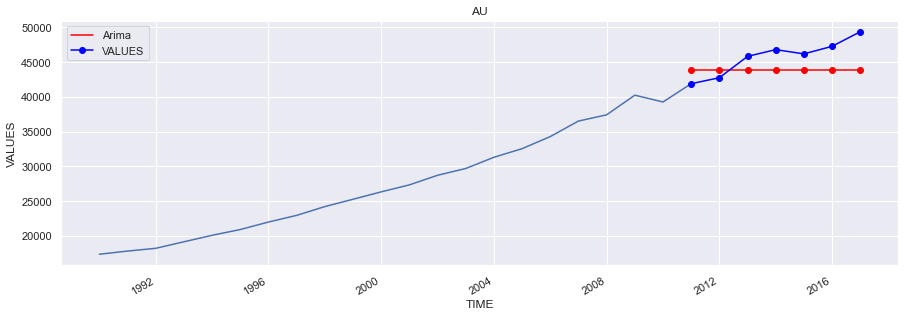

In [14]:
# Running ARIMA with random numbers
model_arima = sm.tsa.arima.ARIMA(au2, order=(0,2,3)) # start 2-0-0 and move to the best
#model_arima_fit = model_arima.fit(disp=-1)
model_arima_fit = model_arima.fit()

# Saving ARIMA predictions
fcast1 = model_arima_fit.forecast(7)[0]

# Passing the same index as the others
fcast1 = pd.Series(fcast1, index=index_7_years)
fcast1 = fcast1.rename("Arima") 

# Ploting the predictions
fig, ax = plt.subplots(figsize=(15,5))
chart = sns.lineplot(x='TIME', y='VALUES', data = au)
chart.set_title('AU')
fcast1.plot(ax=ax, color='red', marker="o", legend=True)
au_v2.plot(ax=ax, color='blue', marker="o", legend=True)

# Printing the AI
print('The MSE of ARIMA is:', mean_squared_error(au_v['VALUES'].values, fcast1.values, squared=False))

In [15]:
###### Option 1: Finding the best value for ARIMA

import itertools
p=d=q=range(0,5)
pdq = list(itertools.product(p,d,q))

for param in pdq:
    try:
        model_arima = ARIMA(au2,order=param)
        model_arima_fit = model_arima.fit()
        print(param,model_arima_fit.aic)
    except:
        continue
    
# The Akaike information criterion (AIC) is an estimator of in-sample prediction error and thereby relative quality of
# statistical models for a given set of data

# It's like the mean squared error in Regression - The smaller the number, the better

The RMSE of auto-arima is:
[nan 43644.354130 45394.538260 47144.722390 48894.906520 50645.090651
 52395.274781]
The MSE of auto-arima is: 3065.74743727046


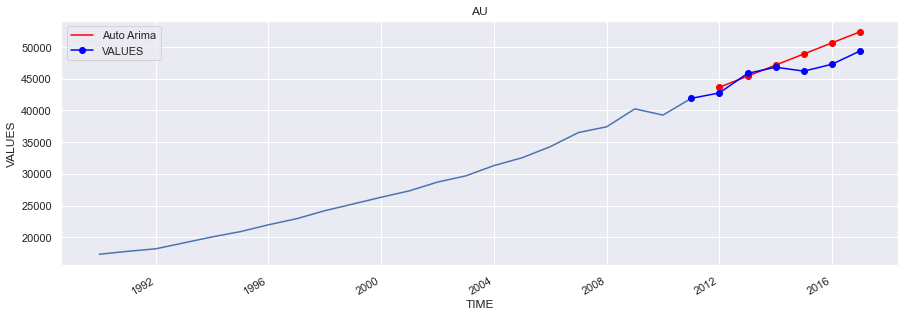

In [16]:
###### Option 2: Auto ARIMA

# Running auto ARIMA 
auto_arima_model = pm.auto_arima(au2, seasonal=False, m=7)

# Read more about setting m
# https://alkaline-ml.com/pmdarima/tips_and_tricks.html

# make your forecasts
fcast2 = auto_arima_model.predict(7) 
fcast2 = pd.Series(fcast2, index=index_7_years)
fcast2 = fcast2.rename("Auto Arima")
print('The RMSE of auto-arima is:')
print(fcast2.values)
# Ploting the predictions
fig, ax = plt.subplots(figsize=(15,5))
chart = sns.lineplot(x='TIME', y='VALUES', data = au)
chart.set_title('AU')
fcast2.plot(ax=ax, color='red', marker="o", legend=True)
au_v2.plot(ax=ax, color='blue', marker="o", legend=True)

# Printing the AI
print('The MSE of auto-arima is:', mean_squared_error(au_v['VALUES'].values, fcast1.values, squared=False))

In [17]:
# Conclusion: Run Both

###  Running Prophet

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 16.


The MSE of prophet is: 1188.9879556988833


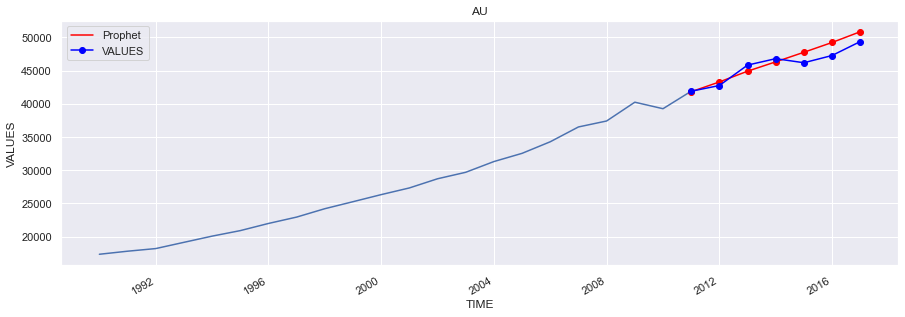

In [18]:
# prepare expected column names
au3 = au.copy()
au3 = au3[['TIME', 'VALUES']]
au3.columns = ['ds', 'y']
au3['ds']= to_datetime(au3['ds'])

# define the model
model = Prophet()
# fit the model
model.fit(au3)

# define the period for which we want a prediction
df_index_7_years = pd.DataFrame(index_7_years)
df_index_7_years.columns = ['ds']
df_index_7_years['ds']= to_datetime(df_index_7_years['ds'])

# use the model to make a forecast
fcast3 = model.predict(df_index_7_years)
fcast3 = pd.Series(fcast3['yhat'].values, index=index_7_years)
fcast3 = fcast3.rename("Prophet")

# Ploting the predictions
fig, ax = plt.subplots(figsize=(15,5))
chart = sns.lineplot(x='TIME', y='VALUES', data = au)
chart.set_title('AU')
fcast3.plot(ax=ax, color='red', marker="o", legend=True)
au_v2.plot(ax=ax, color='blue', marker="o", legend=True)

# Printing the AI
print('The MSE of prophet is:', mean_squared_error(au_v['VALUES'].values, fcast3.values, squared=False))

In [19]:
model.predict(df_index_7_years)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2011-01-01,27484.466852,41256.318173,42407.706476,27484.466852,27484.466852,14331.537827,14331.537827,14331.537827,14331.537827,14331.537827,14331.537827,0.0,0.0,0.0,41816.004679
1,2012-01-01,28970.115088,42775.618466,43862.128000,28946.732373,28993.562113,14319.229180,14319.229180,14319.229180,14319.229180,14319.229180,14319.229180,0.0,0.0,0.0,43289.344269
2,2013-01-01,30459.833594,44321.960529,45454.361732,30369.578694,30547.352669,14452.620321,14452.620321,14452.620321,14452.620321,14452.620321,14452.620321,0.0,0.0,0.0,44912.453915
3,2014-01-01,31945.481831,45741.772501,46913.300517,31774.153267,32114.303050,14375.888942,14375.888942,14375.888942,14375.888942,14375.888942,14375.888942,0.0,0.0,0.0,46321.370773
4,2015-01-01,33431.130067,47141.408857,48401.344345,33155.461591,33679.673920,14331.537827,14331.537827,14331.537827,14331.537827,14331.537827,14331.537827,0.0,0.0,0.0,47762.667895
5,2016-01-01,34916.778304,48557.335002,50011.395549,34527.536628,35273.079861,14319.229180,14319.229180,14319.229180,14319.229180,14319.229180,14319.229180,0.0,0.0,0.0,49236.007484
6,2017-01-01,36406.496809,50098.411860,51580.738195,35890.822356,36894.664972,14452.620321,14452.620321,14452.620321,14452.620321,14452.620321,14452.620321,0.0,0.0,0.0,50859.117130


### Running all Time Series Models Together

In [20]:
import statsmodels.api as sm
#model = sm.tsa.arima.ARIMA(train_data, order=(1,1,2))
#result = model.fit()

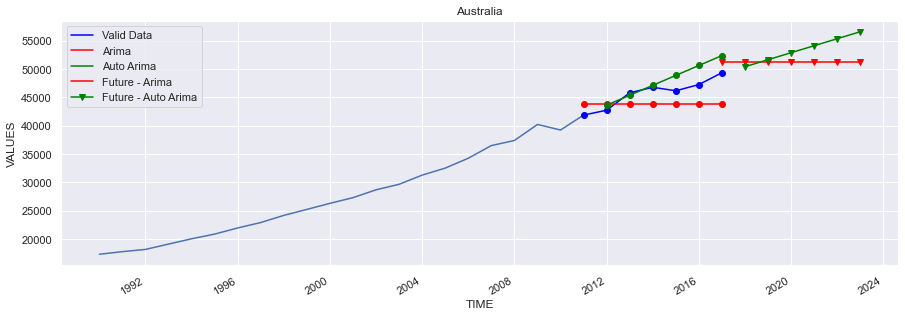

In [21]:
# Step 1 - Arima & Auto-Arima

# creating a country list
countries = forecast_data['COUNTRY'].unique()

countries = ['Australia']

for c in countries:
    # filtering the train data
    train_data = X_train[X_train['COUNTRY'] == c] # 3 columns
    train_data2 = train_data[['TIME', 'VALUES']] # 2 columns
    
    # filtering the valid data
    valid_data = X_valid[X_valid['COUNTRY'] == c]
    valid_data2 = valid_data[['TIME', 'VALUES']]
    
    # all data
    all_data = forecast_data[forecast_data['COUNTRY']==c]
    all_data2 = all_data[['TIME', 'VALUES']]
    
    #convert date column to datetime
    train_data2.set_index('TIME', inplace=True)
    valid_data2.set_index('TIME', inplace=True)
    valid_data2.columns = ['Valid Data']    
    all_data2.set_index('TIME', inplace=True)
    

    # Setting the Valid - Index for 7 years
    index_7_years = pd.date_range(train_data2.index[-1], freq='AS', periods = 7) 
    
    # Setting the Future - Index for 7 years
    future_index_7_years = pd.date_range(valid_data2.index[-1], freq='AS', periods = 7) 
    
    # Dropping all tables
    try:
        del t_fcast1
        del t_fcast2
        #del t_fcast3
        
        del f_fcast1
        del f_fcast2
        #del f_fcast3       
        
    except:
        print("")

    try:
        del df_fcast1
        del df_fcast2
        del df_fcast3
    except:
        print("")
        
    ##############################################################################################################
    ######################################            ARIMA             ##########################################  
    ##############################################################################################################
    
    # THIS IS FOR THE VALIDATION PHASE 
    #try:        
    try:
        # Running ARIMA on Best parameter
        model_arima = sm.tsa.arima.ARIMA(train_data2, order=(0,2,3))
        model_arima_fit = model_arima.fit()

        # Saving ARIMA predictions
        t_fcast1 = model_arima_fit.forecast(7)[0]
        # Passing the same index as the others
        t_fcast1 = pd.Series(t_fcast1, index=index_7_years)
        t_fcast1 = t_fcast1.rename("Arima") 
    except:
        # Running ARIMA on Best parameter
        model_arima = sm.tsa.arima.ARIMA(train_data2, order=(4,1,1))
        model_arima_fit = model_arima.fit()

        # Saving ARIMA predictions
        t_fcast1 = model_arima_fit.forecast(7)[0]
        # Passing the same index as the others
        t_fcast1 = pd.Series(t_fcast1, index=index_7_years)
        t_fcast1 = t_fcast1.rename("Arima") 
    #except:
        #print(c, "Arima Train Error")
        
     # THIS IS FOR THE FUTURE PHASE
    #try:        
    try:
        # Running ARIMA on Best parameter
        model_arima = sm.tsa.arima.ARIMA(all_data2, order=(0,2,3))
        model_arima_fit = model_arima.fit()

        # Saving ARIMA predictions
        f_fcast1 = model_arima_fit.forecast(7)[0]
        # Passing the same index as the others
        f_fcast1 = pd.Series(f_fcast1, index=future_index_7_years)
        f_fcast1 = f_fcast1.rename("Future - Arima") 
    except:
        # Running ARIMA on Best parameter
        model_arima = sm.tsa.arima.ARIMA(all_data2, order=(4,1,0))
        model_arima_fit = model_arima.fit(disp=-1)

        # Saving ARIMA predictions
        f_fcast1 = model_arima_fit.forecast(7)[0]
        # Passing the same index as the others
        f_fcast1 = pd.Series(f_fcast1, index=future_index_7_years)
        f_fcast1 = f_fcast1.rename("Future - Arima") 
    #except:
        #print(c, "Arima Future Error")   
        
    ##############################################################################################################
    ######################################      AUTO - ARIMA             ######################################### 
    ##############################################################################################################
    
    # THIS IS FOR THE VALIDATION PHASE
    #try:
    # Running auto ARIMA 
    auto_arima_model = pm.auto_arima(train_data2, seasonal=False, m=7)

    # make your forecasts
    t_fcast2 = auto_arima_model.predict(7) 
    t_fcast2 = pd.Series(t_fcast2, index=index_7_years)
    t_fcast2 = t_fcast2.rename("Auto Arima")

    #except:
        #print(c, "Auto Arima Train Error") 
        
     # THIS IS FOR THE FUTURE PHASE
    #try:
        # Running auto ARIMA Future
    auto_arima_model = pm.auto_arima(all_data2, seasonal=False, m=7)

    # make your forecasts
    f_fcast2 = auto_arima_model.predict(7) 
    f_fcast2 = pd.Series(f_fcast2, index=future_index_7_years)
    f_fcast2 = f_fcast2.rename("Future - Auto Arima")

    #except:
        #print(c, "Auto Arima Future Error")  
        
    ##############################################################################################################
    ########################################      PLOTTING              ##########################################
    ##############################################################################################################
    
    fig, ax = plt.subplots(figsize=(15,5))
    chart = sns.lineplot(x='TIME', y='VALUES', data = train_data)
    chart.set_title(c)
    valid_data2.plot(ax=ax, color='blue', marker="o", legend=True)
    # ploting validation
    try:
        t_fcast1.plot(ax=ax, color='red', marker="o", legend=True)
    except:
        print("")        
    try:
        t_fcast2.plot(ax=ax, color='green', marker="o", legend=True)
    except:
        print("")
        
    # plotting future
    try:
        f_fcast1.plot(ax=ax, color='red', marker="v", legend=True)
    except:
        print("")        
    try:
        f_fcast2.plot(ax=ax, color='green', marker="v", legend=True)
    except:
        print("")    
    

In [22]:
future_index_7_years

DatetimeIndex(['2017-01-01', '2018-01-01', '2019-01-01', '2020-01-01',
               '2021-01-01', '2022-01-01', '2023-01-01'],
              dtype='datetime64[ns]', freq='AS-JAN')

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 16.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 21.


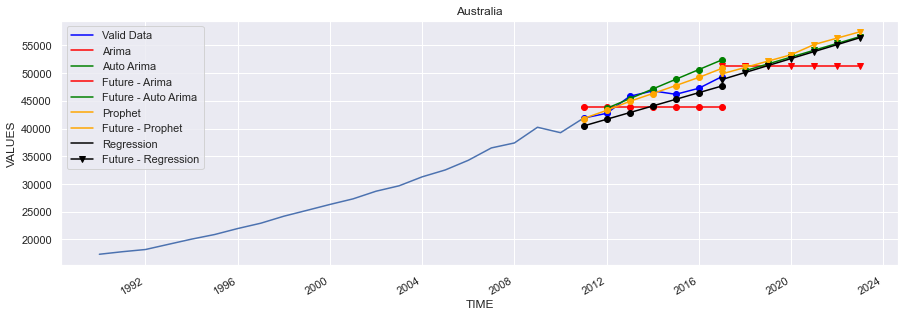

In [23]:
# Step 2 - Adding Prophet and Regression

# creating a country list
countries = forecast_data['COUNTRY'].unique()

countries = ['Australia']

for c in countries:
    # filtering the train data
    train_data = X_train[X_train['COUNTRY'] == c]
    train_data2 = train_data[['TIME', 'VALUES']]
    
    # filtering the valid data
    valid_data = X_valid[X_valid['COUNTRY'] == c]
    valid_data2 = valid_data[['TIME', 'VALUES']]
    
    # all data
    all_data = forecast_data[forecast_data['COUNTRY']==c]
    all_data2 = all_data[['TIME', 'VALUES']]
    
    #convert date column to datetime
    train_data2.set_index('TIME', inplace=True)
    valid_data2.set_index('TIME', inplace=True)
    valid_data2.columns = ['Valid Data']    
    all_data2.set_index('TIME', inplace=True)
    

    # Setting the Valid - Index for 7 years
    index_7_years = pd.date_range(train_data2.index[-1], freq='AS', periods = 7) 
    
    # Setting the Future - Index for 7 years
    future_index_7_years = pd.date_range(valid_data2.index[-1], freq='AS', periods = 7) 
    
    # Dropping all tables
    try:
        del t_fcast1
        del t_fcast2
        del t_fcast3
        del t_fcast4
        
        del f_fcast1
        del f_fcast2
        del f_fcast3       
        del f_fcast4
        
    except:
        print("")

    try:
        del df_fcast1
        del df_fcast2
        del df_fcast3
    except:
        print("")
        
    ##############################################################################################################
    ######################################            ARIMA             ##########################################  
    ##############################################################################################################
    
     # THIS IS FOR THE VALIDATION PHASE 
    #try:        
    try:
        # Running ARIMA on Best parameter
        model_arima = sm.tsa.arima.ARIMA(train_data2, order=(0,2,3))
        model_arima_fit = model_arima.fit()

        # Saving ARIMA predictions
        t_fcast1 = model_arima_fit.forecast(7)[0]
        # Passing the same index as the others
        t_fcast1 = pd.Series(t_fcast1, index=index_7_years)
        t_fcast1 = t_fcast1.rename("Arima") 
    except:
        # Running ARIMA on Best parameter
        model_arima = sm.tsa.arima.ARIMA(train_data2, order=(4,1,1))
        model_arima_fit = model_arima.fit()

        # Saving ARIMA predictions
        t_fcast1 = model_arima_fit.forecast(7)[0]
        # Passing the same index as the others
        t_fcast1 = pd.Series(t_fcast1, index=index_7_years)
        t_fcast1 = t_fcast1.rename("Arima") 
    #except:
        #print(c, "Arima Train Error")
        
     # THIS IS FOR THE FUTURE PHASE
    #try:        
    try:
        # Running ARIMA on Best parameter
        model_arima = sm.tsa.arima.ARIMA(all_data2, order=(0,2,3))
        model_arima_fit = model_arima.fit()

        # Saving ARIMA predictions
        f_fcast1 = model_arima_fit.forecast(7)[0]
        # Passing the same index as the others
        f_fcast1 = pd.Series(f_fcast1, index=future_index_7_years)
        f_fcast1 = f_fcast1.rename("Future - Arima") 
    except:
        # Running ARIMA on Best parameter
        model_arima = sm.tsa.arima.ARIMA(all_data2, order=(4,1,0))
        model_arima_fit = model_arima.fit(disp=-1)

        # Saving ARIMA predictions
        f_fcast1 = model_arima_fit.forecast(7)[0]
        # Passing the same index as the others
        f_fcast1 = pd.Series(f_fcast1, index=future_index_7_years)
        f_fcast1 = f_fcast1.rename("Future - Arima") 
    #except:
        #print(c, "Arima Future Error")   
        
    ##############################################################################################################
    ######################################      AUTO - ARIMA             ######################################### 
    ##############################################################################################################
    
    
    # THIS IS FOR THE VALIDATION PHASE
    #try:
    # Running auto ARIMA 
    auto_arima_model = pm.auto_arima(train_data2, seasonal=False, m=7)

    # make your forecasts
    t_fcast2 = auto_arima_model.predict(7) 
    t_fcast2 = pd.Series(t_fcast2, index=index_7_years)
    t_fcast2 = t_fcast2.rename("Auto Arima")

    #except:
        #print(c, "Auto Arima Train Error") 
        
     # THIS IS FOR THE FUTURE PHASE
    #try:
        # Running auto ARIMA Future
    auto_arima_model = pm.auto_arima(all_data2, seasonal=False, m=7)

    # make your forecasts
    f_fcast2 = auto_arima_model.predict(7) 
    f_fcast2 = pd.Series(f_fcast2, index=future_index_7_years)
    f_fcast2 = f_fcast2.rename("Future - Auto Arima")

    #except:
        #print(c, "Auto Arima Future Error")  

    ##############################################################################################################
    ######################################      PROPHET             ############################################## 
    ##############################################################################################################
    
    # prepare expected column names
    train_data3 = train_data.copy()
    train_data3 = train_data3[['TIME', 'VALUES']]
    train_data3.columns = ['ds', 'y']
    train_data3['ds']= to_datetime(train_data3['ds'])
    
    all_data3 = all_data.copy()
    all_data3 = all_data3[['TIME', 'VALUES']]
    all_data3.columns = ['ds', 'y']
    all_data3['ds']= to_datetime(all_data3['ds'])

    # define the period for which we want a prediction - Valid
    v_df_index_7_years = pd.DataFrame(index_7_years)
    v_df_index_7_years.columns = ['ds']
    v_df_index_7_years['ds']= to_datetime(v_df_index_7_years['ds'])

    # define the period for which we want a prediction - Future
    f_df_index_7_years = pd.DataFrame(future_index_7_years)
    f_df_index_7_years.columns = ['ds']
    f_df_index_7_years['ds']= to_datetime(f_df_index_7_years['ds'])
    
    ############### THIS IS FOR THE VALIDATION PHASE  ##################

    # define the model
    model = Prophet()
    # fit the model
    model.fit(train_data3)

    # use the model to make a forecast
    t_fcast3 = model.predict(v_df_index_7_years)
    t_fcast3 = pd.Series(t_fcast3['yhat'].values, index=index_7_years)
    t_fcast3 = t_fcast3.rename("Prophet")
    
    ############### THIS IS FOR THE VALIDATION PHASE  ##################

    # define the model
    model2 = Prophet()
    # fit the model
    model2.fit(all_data3)

    # use the model to make a forecast
    f_fcast3 = model2.predict(f_df_index_7_years)
    f_fcast3 = pd.Series(f_fcast3['yhat'].values, index=future_index_7_years)
    f_fcast3 = f_fcast3.rename("Future - Prophet")  

    ##############################################################################################################
    ########################################         Regression         ##########################################
    ##############################################################################################################
    
    # Creating Ordinal Dates
    train_data['MonthNumberOrdinal'] = train_data['TIME']
    train_data['MonthNumberOrdinal'] = pd.to_datetime(train_data['MonthNumberOrdinal']).map(datetime.toordinal)

    all_data['MonthNumberOrdinal'] = all_data['TIME']
    all_data['MonthNumberOrdinal'] = pd.to_datetime(all_data['MonthNumberOrdinal']).map(datetime.toordinal)

    # adding the ordinal dates to the prediction dates
    v_df_index_7_years['ForecastDate_Ordinal'] = pd.to_datetime(v_df_index_7_years['ds']).map(datetime.toordinal)
    f_df_index_7_years['ForecastDate_Ordinal'] = pd.to_datetime(f_df_index_7_years['ds']).map(datetime.toordinal)


    # Fitting LR on Valid
    reg = linear_model.LinearRegression()
    reg.fit(train_data['MonthNumberOrdinal'].values.reshape(-1, 1), train_data['VALUES'].values)

    # Making predictions
    t_fcast4 = reg.predict(v_df_index_7_years['ForecastDate_Ordinal'].values.reshape(-1, 1))

    # Passing the same index as the others
    t_fcast4 = pd.Series(t_fcast4, index=index_7_years)
    t_fcast4 = t_fcast4.rename("Regression")

    # Fitting LR on Future
    reg2 = linear_model.LinearRegression()
    reg2.fit(all_data['MonthNumberOrdinal'].values.reshape(-1, 1), all_data['VALUES'].values)

    # Making predictions
    f_fcast4 = reg2.predict(f_df_index_7_years['ForecastDate_Ordinal'].values.reshape(-1, 1))

    # Passing the same index as the others
    f_fcast4 = pd.Series(f_fcast4, index=future_index_7_years)
    f_fcast4 = f_fcast4.rename("Future - Regression")
    
    ##############################################################################################################
    ########################################      SAVING THE MSE        ##########################################
    ##############################################################################################################
    
    t_fcast1_mse = mean_squared_error(valid_data['VALUES'].values, t_fcast1.values, squared=False)
    t_fcast2_mse = mean_squared_error(valid_data['VALUES'].values, t_fcast1.values, squared=False)
    t_fcast3_mse = mean_squared_error(valid_data['VALUES'].values, t_fcast3.values, squared=False)
    t_fcast4_mse = mean_squared_error(valid_data['VALUES'].values, t_fcast4.values, squared=False)
    
    ##############################################################################################################
    ########################################      PLOTTING              ##########################################
    ##############################################################################################################
    
    fig, ax = plt.subplots(figsize=(15,5))
    chart = sns.lineplot(x='TIME', y='VALUES', data = train_data)
    chart.set_title(c)
    valid_data2.plot(ax=ax, color='blue', marker="o", legend=True)
    # ploting validation
    try:
        t_fcast1.plot(ax=ax, color='red', marker="o", legend=True)
    except:
        print("")        
    try:
        t_fcast2.plot(ax=ax, color='green', marker="o", legend=True)
    except:
        print("")
        
    # plotting future
    try:
        f_fcast1.plot(ax=ax, color='red', marker="v", legend=True)
    except:
        print("")        
    try:
        f_fcast2.plot(ax=ax, color='green', marker="v", legend=True)
    except:
        print("") 
    
    t_fcast3.plot(ax=ax, color='orange', marker="o", legend=True)
    f_fcast3.plot(ax=ax, color='orange', marker="v", legend=True)
    
    t_fcast4.plot(ax=ax, color='black', marker="o", legend=True)
    f_fcast4.plot(ax=ax, color='black', marker="v", legend=True)    

In [24]:
v_df_index_7_years

,ds,ForecastDate_Ordinal
0,2011-01-01,734138
1,2012-01-01,734503
2,2013-01-01,734869
3,2014-01-01,735234
4,2015-01-01,735599
5,2016-01-01,735964
6,2017-01-01,736330


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 16.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 21.


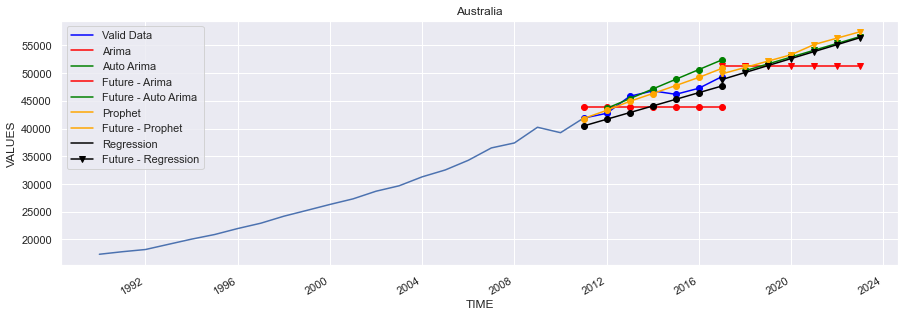

In [25]:
# Step 3 - Saving the results

# creating a country list
countries = forecast_data['COUNTRY'].unique()

countries = ['Australia']

for c in countries:
    # filtering the train data
    train_data = X_train[X_train['COUNTRY'] == c]
    train_data2 = train_data[['TIME', 'VALUES']]
    
    # filtering the valid data
    valid_data = X_valid[X_valid['COUNTRY'] == c]
    valid_data2 = valid_data[['TIME', 'VALUES']]
    
    # all data
    all_data = forecast_data[forecast_data['COUNTRY']==c]
    all_data2 = all_data[['TIME', 'VALUES']]
    
    #convert date column to datetime
    train_data2.set_index('TIME', inplace=True)
    valid_data2.set_index('TIME', inplace=True)
    valid_data2.columns = ['Valid Data']    
    all_data2.set_index('TIME', inplace=True)
    

    # Setting the Valid - Index for 6 years
    index_7_years = pd.date_range(train_data2.index[-1], freq='AS', periods = 7) 
    
    # Setting the Future - Index for 6 years
    future_index_7_years = pd.date_range(valid_data2.index[-1], freq='AS', periods = 7) 
    
    # Dropping all tables
    try:
        del t_fcast1
        del t_fcast2
        del t_fcast3
        del t_fcast4
        
        del f_fcast1
        del f_fcast2
        del f_fcast3 
        del f_fcast4
        
    except:
        print("")

    try:
        del df_fcast1
        del df_fcast2
        del df_fcast3
        del df_fcast4
    except:
        print("")
        
    ##############################################################################################################
    ######################################            ARIMA             ##########################################  
    ##############################################################################################################
    
       # THIS IS FOR THE VALIDATION PHASE 
    #try:        
    try:
        # Running ARIMA on Best parameter
        model_arima = sm.tsa.arima.ARIMA(train_data2, order=(0,2,3))
        model_arima_fit = model_arima.fit()

        # Saving ARIMA predictions
        t_fcast1 = model_arima_fit.forecast(7)[0]
        # Passing the same index as the others
        t_fcast1 = pd.Series(t_fcast1, index=index_7_years)
        t_fcast1 = t_fcast1.rename("Arima") 
    except:
        # Running ARIMA on Best parameter
        model_arima = sm.tsa.arima.ARIMA(train_data2, order=(4,1,1))
        model_arima_fit = model_arima.fit()

        # Saving ARIMA predictions
        t_fcast1 = model_arima_fit.forecast(7)[0]
        # Passing the same index as the others
        t_fcast1 = pd.Series(t_fcast1, index=index_7_years)
        t_fcast1 = t_fcast1.rename("Arima") 
    #except:
        #print(c, "Arima Train Error")
        
     # THIS IS FOR THE FUTURE PHASE
    #try:        
    try:
        # Running ARIMA on Best parameter
        model_arima = sm.tsa.arima.ARIMA(all_data2, order=(0,2,3))
        model_arima_fit = model_arima.fit()

        # Saving ARIMA predictions
        f_fcast1 = model_arima_fit.forecast(7)[0]
        # Passing the same index as the others
        f_fcast1 = pd.Series(f_fcast1, index=future_index_7_years)
        f_fcast1 = f_fcast1.rename("Future - Arima") 
    except:
        # Running ARIMA on Best parameter
        model_arima = sm.tsa.arima.ARIMA(all_data2, order=(4,1,0))
        model_arima_fit = model_arima.fit(disp=-1)

        # Saving ARIMA predictions
        f_fcast1 = model_arima_fit.forecast(7)[0]
        # Passing the same index as the others
        f_fcast1 = pd.Series(f_fcast1, index=future_index_7_years)
        f_fcast1 = f_fcast1.rename("Future - Arima") 
    #except:
        #print(c, "Arima Future Error")  
        
    ##############################################################################################################
    ######################################      AUTO - ARIMA             ######################################### 
    ##############################################################################################################
    
   # THIS IS FOR THE VALIDATION PHASE
    #try:
    # Running auto ARIMA 
    auto_arima_model = pm.auto_arima(train_data2, seasonal=False, m=7)

    # make your forecasts
    t_fcast2 = auto_arima_model.predict(7) 
    t_fcast2 = pd.Series(t_fcast2, index=index_7_years)
    t_fcast2 = t_fcast2.rename("Auto Arima")

    #except:
        #print(c, "Auto Arima Train Error") 
        
     # THIS IS FOR THE FUTURE PHASE
    #try:
        # Running auto ARIMA Future
    auto_arima_model = pm.auto_arima(all_data2, seasonal=False, m=7)

    # make your forecasts
    f_fcast2 = auto_arima_model.predict(7) 
    f_fcast2 = pd.Series(f_fcast2, index=future_index_7_years)
    f_fcast2 = f_fcast2.rename("Future - Auto Arima")

    #except:
        #print(c, "Auto Arima Future Error") 

    ##############################################################################################################
    ######################################      PROPHET             ############################################## 
    ##############################################################################################################
    
    # prepare expected column names
    train_data3 = train_data.copy()
    train_data3 = train_data3[['TIME', 'VALUES']]
    train_data3.columns = ['ds', 'y']
    train_data3['ds']= to_datetime(train_data3['ds'])
    
    all_data3 = all_data.copy()
    all_data3 = all_data3[['TIME', 'VALUES']]
    all_data3.columns = ['ds', 'y']
    all_data3['ds']= to_datetime(all_data3['ds'])

    # define the period for which we want a prediction - Valid
    v_df_index_7_years = pd.DataFrame(index_7_years)
    v_df_index_7_years.columns = ['ds']
    v_df_index_7_years['ds']= to_datetime(v_df_index_7_years['ds'])

    # define the period for which we want a prediction - Future
    f_df_index_7_years = pd.DataFrame(future_index_7_years)
    f_df_index_7_years.columns = ['ds']
    f_df_index_7_years['ds']= to_datetime(f_df_index_7_years['ds'])
    
    ############### THIS IS FOR THE VALIDATION PHASE  ##################

    # define the model
    model = Prophet()
    # fit the model
    model.fit(train_data3)

    # use the model to make a forecast
    t_fcast3 = model.predict(v_df_index_7_years)
    t_fcast3 = pd.Series(t_fcast3['yhat'].values, index=index_7_years)
    t_fcast3 = t_fcast3.rename("Prophet")
    
    ############### THIS IS FOR THE VALIDATION PHASE  ##################

    # define the model
    model2 = Prophet()
    # fit the model
    model2.fit(all_data3)

    # use the model to make a forecast
    f_fcast3 = model2.predict(f_df_index_7_years)
    f_fcast3 = pd.Series(f_fcast3['yhat'].values, index=future_index_7_years)
    f_fcast3 = f_fcast3.rename("Future - Prophet")  

    ##############################################################################################################
    ########################################         Regression         ##########################################
    ##############################################################################################################
    
    # Creating Ordinal Dates
    train_data['MonthNumberOrdinal'] = train_data['TIME']
    train_data['MonthNumberOrdinal'] = pd.to_datetime(train_data['MonthNumberOrdinal']).map(datetime.toordinal)

    all_data['MonthNumberOrdinal'] = all_data['TIME']
    all_data['MonthNumberOrdinal'] = pd.to_datetime(all_data['MonthNumberOrdinal']).map(datetime.toordinal)

    # adding the ordinal dates to the prediction dates
    v_df_index_7_years['ForecastDate_Ordinal'] = pd.to_datetime(v_df_index_7_years['ds']).map(datetime.toordinal)
    f_df_index_7_years['ForecastDate_Ordinal'] = pd.to_datetime(f_df_index_7_years['ds']).map(datetime.toordinal)


    # Fitting LR on Valid
    reg = linear_model.LinearRegression()
    reg.fit(train_data['MonthNumberOrdinal'].values.reshape(-1, 1), train_data['VALUES'].values)

    # Making predictions
    t_fcast4 = reg.predict(v_df_index_7_years['ForecastDate_Ordinal'].values.reshape(-1, 1))

    # Passing the same index as the others
    t_fcast4 = pd.Series(t_fcast4, index=index_7_years)
    t_fcast4 = t_fcast4.rename("Regression")

    # Fitting LR on Future
    reg2 = linear_model.LinearRegression()
    reg2.fit(all_data['MonthNumberOrdinal'].values.reshape(-1, 1), all_data['VALUES'].values)

    # Making predictions
    f_fcast4 = reg2.predict(f_df_index_7_years['ForecastDate_Ordinal'].values.reshape(-1, 1))

    # Passing the same index as the others
    f_fcast4 = pd.Series(f_fcast4, index=future_index_7_years)
    f_fcast4 = f_fcast4.rename("Future - Regression")
    
    ##############################################################################################################
    ########################################      SAVING THE MSE        ##########################################
    ##############################################################################################################
    
    t_fcast1_mse = mean_squared_error(valid_data['VALUES'].values, t_fcast1.values, squared=False)
    t_fcast2_mse = mean_squared_error(valid_data['VALUES'].values, t_fcast1.values, squared=False)
    t_fcast3_mse = mean_squared_error(valid_data['VALUES'].values, t_fcast3.values, squared=False)
    t_fcast4_mse = mean_squared_error(valid_data['VALUES'].values, t_fcast4.values, squared=False)
    
    ##############################################################################################################
    ########################################      PLOTTING              ##########################################
    ##############################################################################################################
    
    fig, ax = plt.subplots(figsize=(15,5))
    chart = sns.lineplot(x='TIME', y='VALUES', data = train_data)
    chart.set_title(c)
    valid_data2.plot(ax=ax, color='blue', marker="o", legend=True)
    # ploting validation
    try:
        t_fcast1.plot(ax=ax, color='red', marker="o", legend=True)
    except:
        print("")        
    try:
        t_fcast2.plot(ax=ax, color='green', marker="o", legend=True)
    except:
        print("")
        
    # plotting future
    try:
        f_fcast1.plot(ax=ax, color='red', marker="v", legend=True)
    except:
        print("")        
    try:
        f_fcast2.plot(ax=ax, color='green', marker="v", legend=True)
    except:
        print("") 
    
    t_fcast3.plot(ax=ax, color='orange', marker="o", legend=True)
    f_fcast3.plot(ax=ax, color='orange', marker="v", legend=True)
    
    t_fcast4.plot(ax=ax, color='black', marker="o", legend=True)
    f_fcast4.plot(ax=ax, color='black', marker="v", legend=True)  
        
    ##############################################################################################################
    ########################################      SAVING THE RESULTS     #########################################
    ##############################################################################################################
    
    try:
        # Creating a DF for fcast1
        t_fcast1 = t_fcast1.reset_index()
        t_fcast1.columns = ['Date','Arima ForecastValue Validation']

        f_fcast1 = f_fcast1.reset_index()
        f_fcast1.columns = ['Date','Arima ForecastValue Future']

        # Creating the extra columns
        t_fcast1['Arima ForecastValue Future'] = np.nan
        f_fcast1['Arima ForecastValue Validation'] = np.nan

        # reordering 1 only
        t_fcast1 = t_fcast1[['Date','Arima ForecastValue Future','Arima ForecastValue Validation']]

        # Joining them together
        df_fcast1 = pd.concat([t_fcast1, f_fcast1], axis=0)
        df_fcast1['Country'] = c
        df_fcast1['ML Method'] = 'Arima'
        df_fcast1['Arima MSE'] = t_fcast1_mse
    
    except:
        df_fcast1 = pd.DataFrame({'Date': [np.nan], 'Arima ForecastValue Future': [np.nan],'Arima ForecastValue Validation': [np.nan], 'Country':[c], 'ML Method':['Arima'], 'Arima MSE':[np.nan]})

    try:
        # Creating a DF for fcast2
        t_fcast2 = t_fcast2.reset_index()
        t_fcast2.columns = ['Date','Auto-Arima ForecastValue Validation']

        f_fcast2 = f_fcast2.reset_index()
        f_fcast2.columns = ['Date','Auto-Arima ForecastValue Future']

        # Creating the extra columns
        t_fcast2['Auto-Arima ForecastValue Future'] = np.nan
        f_fcast2['Auto-Arima ForecastValue Validation'] = np.nan

        # reordering 1 only
        t_fcast2 = t_fcast2[['Date','Auto-Arima ForecastValue Future','Auto-Arima ForecastValue Validation']]

        # Joining them together
        df_fcast2 = pd.concat([t_fcast2, f_fcast2], axis=0)
        df_fcast2['Country'] = c
        df_fcast2['ML Method'] = 'Auto-Arima'
        df_fcast2['Auto-Arima MSE'] = t_fcast2_mse
    
    except:
        df_fcast2 = pd.DataFrame({'Date': [np.nan], 'Auto-Arima ForecastValue Future': [np.nan],'Auto-Arima ForecastValue Validation': [np.nan], 'Country':[c], 'ML Method':['Auto-Arima']})
        
    try:
        # Creating a DF for fcast3
        t_fcast3 = t_fcast3.reset_index()
        t_fcast3.columns = ['Date','Prophet ForecastValue Validation']

        f_fcast3 = f_fcast3.reset_index()
        f_fcast3.columns = ['Date','Prophet ForecastValue Future']

        # Creating the extra columns
        t_fcast3['Prophet ForecastValue Future'] = np.nan
        f_fcast3['Prophet ForecastValue Validation'] = np.nan

        # reordering 1 only
        t_fcast3 = t_fcast3[['Date','Prophet ForecastValue Future','Prophet ForecastValue Validation']]

        # Joining them together
        df_fcast3 = pd.concat([t_fcast3, f_fcast3], axis=0)
        df_fcast3['Country'] = c
        df_fcast3['ML Method'] = 'Prophet'
        df_fcast3['Prophet MSE'] = t_fcast3_mse
    
    except:
        df_fcast3 = pd.DataFrame({'Date': [np.nan], 'Prophet ForecastValue Future': [np.nan],'Prophet ForecastValue Validation': [np.nan], 'Country':[c], 'ML Method':['Auto-Arima']})
        
    try:
        # Creating a DF for fcast4
        t_fcast4 = t_fcast4.reset_index()
        t_fcast4.columns = ['Date','Regression ForecastValue Validation']

        f_fcast4 = f_fcast4.reset_index()
        f_fcast4.columns = ['Date','Regression ForecastValue Future']

        # Creating the extra columns
        t_fcast4['Regression ForecastValue Future'] = np.nan
        f_fcast4['Regression ForecastValue Validation'] = np.nan

        # reordering 1 only
        t_fcast4 = t_fcast4[['Date','Regression ForecastValue Future','Regression ForecastValue Validation']]

        # Joining them together
        df_fcast4 = pd.concat([t_fcast4, f_fcast4], axis=0)
        df_fcast4['Country'] = c
        df_fcast4['ML Method'] = 'Regression'
        df_fcast4['Regression MSE'] = t_fcast4_mse
        df_fcast4['Regression Slope'] = reg2.coef_[0]
        df_fcast4['Regression Trend Direction'] = np.where(df_fcast4['Regression Slope']<=0, 'Negative Trend', 'Positive Trend')
        df_fcast4['Regression Slope Monthly Change Proj'] = df_fcast4['Regression ForecastValue Future'].iloc[-1] - df_fcast4['Regression ForecastValue Future'].iloc[-2]
    
    except:
        df_fcast4 = pd.DataFrame({'Date': [np.nan], 'Regression ForecastValue Future': [np.nan],'Regression ForecastValue Validation': [np.nan], 'Country':[c], 'ML Method':['Auto-Arima'], 'Regression Slope':[np.nan], 'Regression Trend Direction':[np.nan], 'Regression Slope Monthly Change Proj':[np.nan]})
        
    # Aggregating the data to avoid duplication
    df_fcast1 = df_fcast1.groupby(['Date', 'Country','ML Method'], as_index = False).agg({'Arima ForecastValue Future':'sum','Arima ForecastValue Validation':'sum','Arima MSE':'max'})
    df_fcast2 = df_fcast2.groupby(['Date', 'Country','ML Method'], as_index = False).agg({'Auto-Arima ForecastValue Future':'sum','Auto-Arima ForecastValue Validation':'sum','Auto-Arima MSE':'max'})
    df_fcast3 = df_fcast3.groupby(['Date', 'Country','ML Method'], as_index = False).agg({'Prophet ForecastValue Future':'sum','Prophet ForecastValue Validation':'sum','Prophet MSE':'max'})
    df_fcast4 = df_fcast4.groupby(['Date', 'Country','ML Method', 'Regression Trend Direction'], as_index = False).agg({'Regression ForecastValue Future':'sum','Regression ForecastValue Validation':'sum','Regression MSE':'max','Regression Slope':'max','Regression Slope Monthly Change Proj':'max'})

    # joining them all together
    all_forecasts = df_fcast1.merge(df_fcast2[['Date','Auto-Arima ForecastValue Future','Auto-Arima ForecastValue Validation', 'Auto-Arima MSE']], how = 'left', on ='Date')
    all_forecasts = all_forecasts.merge(df_fcast3[['Date','Prophet ForecastValue Future', 'Prophet ForecastValue Validation', 'Prophet MSE']], how = 'left', on ='Date')
    all_forecasts = all_forecasts.merge(df_fcast4[['Date','Regression ForecastValue Future', 'Regression ForecastValue Validation', 'Regression MSE', 'Regression Slope','Regression Slope Monthly Change Proj','Regression Trend Direction']], how = 'left', on ='Date')

    # Saving the predictions in a DF
    try:
        final_forecasts = pd.concat([final_forecasts, all_forecasts], ignore_index = True)
    except:
        final_forecasts = all_forecasts    

In [26]:
all_forecasts

,Date,Country,ML Method,Arima ForecastValue Future,Arima ForecastValue Validation,Arima MSE,Auto-Arima ForecastValue Future,Auto-Arima ForecastValue Validation,Auto-Arima MSE,Prophet ForecastValue Future,Prophet ForecastValue Validation,Prophet MSE,Regression ForecastValue Future,Regression ForecastValue Validation,Regression MSE,Regression Slope,Regression Slope Monthly Change Proj,Regression Trend Direction
0,2011-01-01,Australia,Arima,0.000000,43834.858527,3065.747437,0.000000,0.000000,3065.747437,0.000000,41816.004679,1188.987956,0.000000,40479.487055,1833.553097,3.450056,1259.270378,Positive Trend
1,2012-01-01,Australia,Arima,0.000000,43834.858527,3065.747437,0.000000,43644.354130,3065.747437,0.000000,43289.344269,1188.987956,0.000000,41679.244284,1833.553097,3.450056,1259.270378,Positive Trend
2,2013-01-01,Australia,Arima,0.000000,43834.858527,3065.747437,0.000000,45394.538260,3065.747437,0.000000,44912.453915,1188.987956,0.000000,42882.288519,1833.553097,3.450056,1259.270378,Positive Trend
3,2014-01-01,Australia,Arima,0.000000,43834.858527,3065.747437,0.000000,47144.722390,3065.747437,0.000000,46321.370773,1188.987956,0.000000,44082.045747,1833.553097,3.450056,1259.270378,Positive Trend
4,2015-01-01,Australia,Arima,0.000000,43834.858527,3065.747437,0.000000,48894.906520,3065.747437,0.000000,47762.667895,1188.987956,0.000000,45281.802976,1833.553097,3.450056,1259.270378,Positive Trend
5,2016-01-01,Australia,Arima,0.000000,43834.858527,3065.747437,0.000000,50645.090651,3065.747437,0.000000,49236.007484,1188.987956,0.000000,46481.560205,1833.553097,3.450056,1259.270378,Positive Trend
6,2017-01-01,Australia,Arima,51303.765979,43834.858527,3065.747437,0.000000,52395.274781,3065.747437,49867.090480,50859.117130,1188.987956,48850.286020,47684.604440,1833.553097,3.450056,1259.270378,Positive Trend
7,2018-01-01,Australia,Arima,51303.765979,0.000000,3065.747437,50431.032685,0.000000,3065.747437,51024.186471,0.000000,1188.987956,50109.556398,0.000000,1833.553097,3.450056,1259.270378,Positive Trend
8,2019-01-01,Australia,Arima,51303.765979,0.000000,3065.747437,51665.762148,0.000000,3065.747437,52174.736426,0.000000,1188.987956,51368.826775,0.000000,1833.553097,3.450056,1259.270378,Positive Trend
9,2020-01-01,Australia,Arima,51303.765979,0.000000,3065.747437,52900.491611,0.000000,3065.747437,53318.889886,0.000000,1188.987956,52628.097153,0.000000,1833.553097,3.450056,1259.270378,Positive Trend


In [27]:
df_fcast2

,Date,Country,ML Method,Auto-Arima ForecastValue Future,Auto-Arima ForecastValue Validation,Auto-Arima MSE
0,2011-01-01,Australia,Auto-Arima,0.000000,0.000000,3065.747437
1,2012-01-01,Australia,Auto-Arima,0.000000,43644.354130,3065.747437
2,2013-01-01,Australia,Auto-Arima,0.000000,45394.538260,3065.747437
3,2014-01-01,Australia,Auto-Arima,0.000000,47144.722390,3065.747437
4,2015-01-01,Australia,Auto-Arima,0.000000,48894.906520,3065.747437
5,2016-01-01,Australia,Auto-Arima,0.000000,50645.090651,3065.747437
6,2017-01-01,Australia,Auto-Arima,0.000000,52395.274781,3065.747437
7,2018-01-01,Australia,Auto-Arima,50431.032685,0.000000,3065.747437
8,2019-01-01,Australia,Auto-Arima,51665.762148,0.000000,3065.747437
9,2020-01-01,Australia,Auto-Arima,52900.491611,0.000000,3065.747437


In [28]:
df_fcast1.merge(df_fcast2[['Date','Auto-Arima ForecastValue Future','Auto-Arima ForecastValue Validation', 'Auto-Arima MSE']], how = 'left', on ='Date')

,Date,Country,ML Method,Arima ForecastValue Future,Arima ForecastValue Validation,Arima MSE,Auto-Arima ForecastValue Future,Auto-Arima ForecastValue Validation,Auto-Arima MSE
0,2011-01-01,Australia,Arima,0.000000,43834.858527,3065.747437,0.000000,0.000000,3065.747437
1,2012-01-01,Australia,Arima,0.000000,43834.858527,3065.747437,0.000000,43644.354130,3065.747437
2,2013-01-01,Australia,Arima,0.000000,43834.858527,3065.747437,0.000000,45394.538260,3065.747437
3,2014-01-01,Australia,Arima,0.000000,43834.858527,3065.747437,0.000000,47144.722390,3065.747437
4,2015-01-01,Australia,Arima,0.000000,43834.858527,3065.747437,0.000000,48894.906520,3065.747437
5,2016-01-01,Australia,Arima,0.000000,43834.858527,3065.747437,0.000000,50645.090651,3065.747437
6,2017-01-01,Australia,Arima,51303.765979,43834.858527,3065.747437,0.000000,52395.274781,3065.747437
7,2018-01-01,Australia,Arima,51303.765979,0.000000,3065.747437,50431.032685,0.000000,3065.747437
8,2019-01-01,Australia,Arima,51303.765979,0.000000,3065.747437,51665.762148,0.000000,3065.747437
9,2020-01-01,Australia,Arima,51303.765979,0.000000,3065.747437,52900.491611,0.000000,3065.747437


In [29]:
df_fcast1.merge(df_fcast2[['Date','Auto-Arima ForecastValue Future','Auto-Arima ForecastValue Validation', 'Auto-Arima MSE']], how = 'left', on ='Date')

,Date,Country,ML Method,Arima ForecastValue Future,Arima ForecastValue Validation,Arima MSE,Auto-Arima ForecastValue Future,Auto-Arima ForecastValue Validation,Auto-Arima MSE
0,2011-01-01,Australia,Arima,0.000000,43834.858527,3065.747437,0.000000,0.000000,3065.747437
1,2012-01-01,Australia,Arima,0.000000,43834.858527,3065.747437,0.000000,43644.354130,3065.747437
2,2013-01-01,Australia,Arima,0.000000,43834.858527,3065.747437,0.000000,45394.538260,3065.747437
3,2014-01-01,Australia,Arima,0.000000,43834.858527,3065.747437,0.000000,47144.722390,3065.747437
4,2015-01-01,Australia,Arima,0.000000,43834.858527,3065.747437,0.000000,48894.906520,3065.747437
5,2016-01-01,Australia,Arima,0.000000,43834.858527,3065.747437,0.000000,50645.090651,3065.747437
6,2017-01-01,Australia,Arima,51303.765979,43834.858527,3065.747437,0.000000,52395.274781,3065.747437
7,2018-01-01,Australia,Arima,51303.765979,0.000000,3065.747437,50431.032685,0.000000,3065.747437
8,2019-01-01,Australia,Arima,51303.765979,0.000000,3065.747437,51665.762148,0.000000,3065.747437
9,2020-01-01,Australia,Arima,51303.765979,0.000000,3065.747437,52900.491611,0.000000,3065.747437


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 16.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 16.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_se

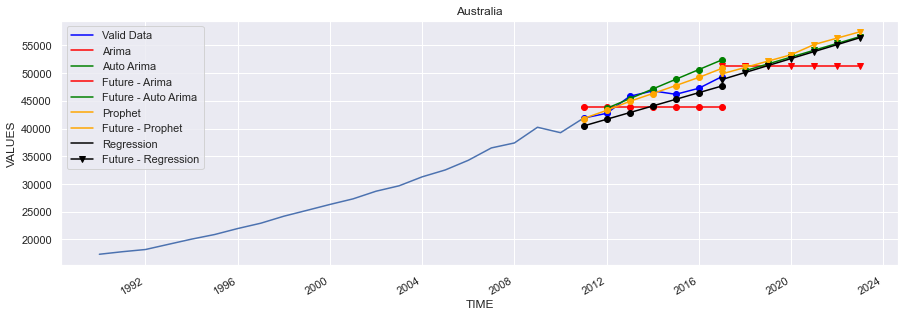

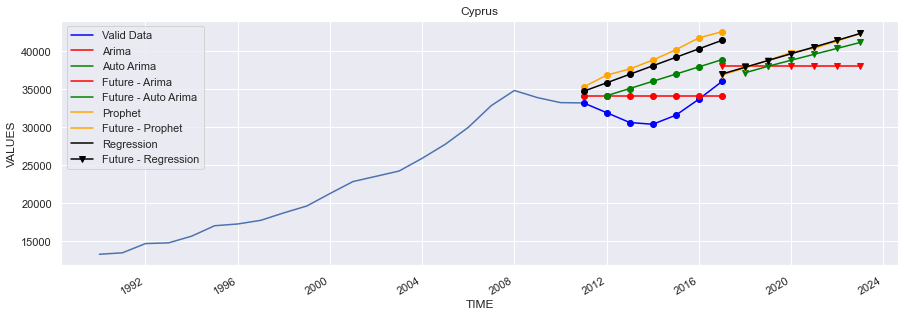

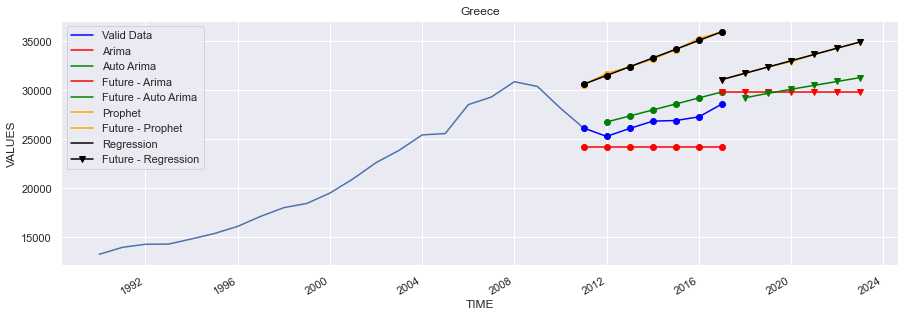

In [30]:
# Step 4 - Testing it on more countries

# creating a country list
countries = forecast_data['COUNTRY'].unique()

countries = ['Australia', 'Cyprus', 'Greece']

for c in countries:
    # filtering the train data
    train_data = X_train[X_train['COUNTRY'] == c]
    train_data2 = train_data[['TIME', 'VALUES']]
    
    # filtering the valid data
    valid_data = X_valid[X_valid['COUNTRY'] == c]
    valid_data2 = valid_data[['TIME', 'VALUES']]
    
    # all data
    all_data = forecast_data[forecast_data['COUNTRY']==c]
    all_data2 = all_data[['TIME', 'VALUES']]
    
    #convert date column to datetime
    train_data2.set_index('TIME', inplace=True)
    valid_data2.set_index('TIME', inplace=True)
    valid_data2.columns = ['Valid Data']    
    all_data2.set_index('TIME', inplace=True)
    

    # Setting the Valid - Index for 6 years
    index_7_years = pd.date_range(train_data2.index[-1], freq='AS', periods = 7) 
    
    # Setting the Future - Index for 6 years
    future_index_7_years = pd.date_range(valid_data2.index[-1], freq='AS', periods = 7) 
    
    # Dropping all tables
    try:
        del t_fcast1
        del t_fcast2
        del t_fcast3
        del t_fcast4
        
        del f_fcast1
        del f_fcast2
        del f_fcast3 
        del f_fcast4
        
    except:
        print("")

    try:
        del df_fcast1
        del df_fcast2
        del df_fcast3
        del df_fcast4
    except:
        print("")
        
    ##############################################################################################################
    ######################################            ARIMA             ##########################################  
    ##############################################################################################################
    
    # THIS IS FOR THE VALIDATION PHASE 
    #try:        
    try:
        # Running ARIMA on Best parameter
        model_arima = sm.tsa.arima.ARIMA(train_data2, order=(0,2,3))
        model_arima_fit = model_arima.fit()

        # Saving ARIMA predictions
        t_fcast1 = model_arima_fit.forecast(7)[0]
        # Passing the same index as the others
        t_fcast1 = pd.Series(t_fcast1, index=index_7_years)
        t_fcast1 = t_fcast1.rename("Arima") 
    except:
        # Running ARIMA on Best parameter
        model_arima = sm.tsa.arima.ARIMA(train_data2, order=(4,1,1))
        model_arima_fit = model_arima.fit()

        # Saving ARIMA predictions
        t_fcast1 = model_arima_fit.forecast(7)[0]
        # Passing the same index as the others
        t_fcast1 = pd.Series(t_fcast1, index=index_7_years)
        t_fcast1 = t_fcast1.rename("Arima") 
    #except:
        #print(c, "Arima Train Error")
        
     # THIS IS FOR THE FUTURE PHASE
    #try:        
    try:
        # Running ARIMA on Best parameter
        model_arima = sm.tsa.arima.ARIMA(all_data2, order=(0,2,3))
        model_arima_fit = model_arima.fit()

        # Saving ARIMA predictions
        f_fcast1 = model_arima_fit.forecast(7)[0]
        # Passing the same index as the others
        f_fcast1 = pd.Series(f_fcast1, index=future_index_7_years)
        f_fcast1 = f_fcast1.rename("Future - Arima") 
    except:
        # Running ARIMA on Best parameter
        model_arima = sm.tsa.arima.ARIMA(all_data2, order=(4,1,0))
        model_arima_fit = model_arima.fit(disp=-1)

        # Saving ARIMA predictions
        f_fcast1 = model_arima_fit.forecast(7)[0]
        # Passing the same index as the others
        f_fcast1 = pd.Series(f_fcast1, index=future_index_7_years)
        f_fcast1 = f_fcast1.rename("Future - Arima") 
    #except:
        #print(c, "Arima Future Error")  
        
    ##############################################################################################################
    ######################################      AUTO - ARIMA             ######################################### 
    ##############################################################################################################
    
   # THIS IS FOR THE VALIDATION PHASE
    #try:
    # Running auto ARIMA 
    auto_arima_model = pm.auto_arima(train_data2, seasonal=False, m=7)

    # make your forecasts
    t_fcast2 = auto_arima_model.predict(7) 
    t_fcast2 = pd.Series(t_fcast2, index=index_7_years)
    t_fcast2 = t_fcast2.rename("Auto Arima")

    #except:
        #print(c, "Auto Arima Train Error") 
        
     # THIS IS FOR THE FUTURE PHASE
    #try:
        # Running auto ARIMA Future
    auto_arima_model = pm.auto_arima(all_data2, seasonal=False, m=7)

    # make your forecasts
    f_fcast2 = auto_arima_model.predict(7) 
    f_fcast2 = pd.Series(f_fcast2, index=future_index_7_years)
    f_fcast2 = f_fcast2.rename("Future - Auto Arima")

    #except:
        #print(c, "Auto Arima Future Error") 

    ##############################################################################################################
    ######################################      PROPHET             ############################################## 
    ##############################################################################################################
    
    # prepare expected column names
    train_data3 = train_data.copy()
    train_data3 = train_data3[['TIME', 'VALUES']]
    train_data3.columns = ['ds', 'y']
    train_data3['ds']= to_datetime(train_data3['ds'])
    
    all_data3 = all_data.copy()
    all_data3 = all_data3[['TIME', 'VALUES']]
    all_data3.columns = ['ds', 'y']
    all_data3['ds']= to_datetime(all_data3['ds'])

    # define the period for which we want a prediction - Valid
    v_df_index_7_years = pd.DataFrame(index_7_years)
    v_df_index_7_years.columns = ['ds']
    v_df_index_7_years['ds']= to_datetime(v_df_index_7_years['ds'])

    # define the period for which we want a prediction - Future
    f_df_index_7_years = pd.DataFrame(future_index_7_years)
    f_df_index_7_years.columns = ['ds']
    f_df_index_7_years['ds']= to_datetime(f_df_index_7_years['ds'])
    
    ############### THIS IS FOR THE VALIDATION PHASE  ##################

    # define the model
    model = Prophet()
    # fit the model
    model.fit(train_data3)

    # use the model to make a forecast
    t_fcast3 = model.predict(v_df_index_7_years)
    t_fcast3 = pd.Series(t_fcast3['yhat'].values, index=index_7_years)
    t_fcast3 = t_fcast3.rename("Prophet")
    
    ############### THIS IS FOR THE VALIDATION PHASE  ##################

    # define the model
    model2 = Prophet()
    # fit the model
    model2.fit(all_data3)

    # use the model to make a forecast
    f_fcast3 = model2.predict(f_df_index_7_years)
    f_fcast3 = pd.Series(f_fcast3['yhat'].values, index=future_index_7_years)
    f_fcast3 = f_fcast3.rename("Future - Prophet")  

    ##############################################################################################################
    ########################################         Regression         ##########################################
    ##############################################################################################################
    
    # Creating Ordinal Dates
    train_data['MonthNumberOrdinal'] = train_data['TIME']
    train_data['MonthNumberOrdinal'] = pd.to_datetime(train_data['MonthNumberOrdinal']).map(datetime.toordinal)

    all_data['MonthNumberOrdinal'] = all_data['TIME']
    all_data['MonthNumberOrdinal'] = pd.to_datetime(all_data['MonthNumberOrdinal']).map(datetime.toordinal)

    # adding the ordinal dates to the prediction dates
    v_df_index_7_years['ForecastDate_Ordinal'] = pd.to_datetime(v_df_index_7_years['ds']).map(datetime.toordinal)
    f_df_index_7_years['ForecastDate_Ordinal'] = pd.to_datetime(f_df_index_7_years['ds']).map(datetime.toordinal)


    # Fitting LR on Valid
    reg = linear_model.LinearRegression()
    reg.fit(train_data['MonthNumberOrdinal'].values.reshape(-1, 1), train_data['VALUES'].values)

    # Making predictions
    t_fcast4 = reg.predict(v_df_index_7_years['ForecastDate_Ordinal'].values.reshape(-1, 1))

    # Passing the same index as the others
    t_fcast4 = pd.Series(t_fcast4, index=index_7_years)
    t_fcast4 = t_fcast4.rename("Regression")

    # Fitting LR on Future
    reg2 = linear_model.LinearRegression()
    reg2.fit(all_data['MonthNumberOrdinal'].values.reshape(-1, 1), all_data['VALUES'].values)

    # Making predictions
    f_fcast4 = reg2.predict(f_df_index_7_years['ForecastDate_Ordinal'].values.reshape(-1, 1))

    # Passing the same index as the others
    f_fcast4 = pd.Series(f_fcast4, index=future_index_7_years)
    f_fcast4 = f_fcast4.rename("Future - Regression")
    
    ##############################################################################################################
    ########################################      SAVING THE MSE        ##########################################
    ##############################################################################################################
    
    t_fcast1_mse = mean_squared_error(valid_data['VALUES'].values, t_fcast1.values, squared=False)
    t_fcast2_mse = mean_squared_error(valid_data['VALUES'].values, t_fcast1.values, squared=False)
    t_fcast3_mse = mean_squared_error(valid_data['VALUES'].values, t_fcast3.values, squared=False)
    t_fcast4_mse = mean_squared_error(valid_data['VALUES'].values, t_fcast4.values, squared=False)
    
    ##############################################################################################################
    ########################################      PLOTTING              ##########################################
    ##############################################################################################################
    
    fig, ax = plt.subplots(figsize=(15,5))
    chart = sns.lineplot(x='TIME', y='VALUES', data = train_data)
    chart.set_title(c)
    valid_data2.plot(ax=ax, color='blue', marker="o", legend=True)
    # ploting validation
    try:
        t_fcast1.plot(ax=ax, color='red', marker="o", legend=True)
    except:
        print("")        
    try:
        t_fcast2.plot(ax=ax, color='green', marker="o", legend=True)
    except:
        print("")
        
    # plotting future
    try:
        f_fcast1.plot(ax=ax, color='red', marker="v", legend=True)
    except:
        print("")        
    try:
        f_fcast2.plot(ax=ax, color='green', marker="v", legend=True)
    except:
        print("") 
    
    t_fcast3.plot(ax=ax, color='orange', marker="o", legend=True)
    f_fcast3.plot(ax=ax, color='orange', marker="v", legend=True)
    
    t_fcast4.plot(ax=ax, color='black', marker="o", legend=True)
    f_fcast4.plot(ax=ax, color='black', marker="v", legend=True)  
        
    ##############################################################################################################
    ########################################      SAVING THE RESULTS     #########################################
    ##############################################################################################################
    
    try:
        # Creating a DF for fcast1
        t_fcast1 = t_fcast1.reset_index()
        t_fcast1.columns = ['Date','Arima ForecastValue Validation']

        f_fcast1 = f_fcast1.reset_index()
        f_fcast1.columns = ['Date','Arima ForecastValue Future']

        # Creating the extra columns
        t_fcast1['Arima ForecastValue Future'] = np.nan
        f_fcast1['Arima ForecastValue Validation'] = np.nan

        # reordering 1 only
        t_fcast1 = t_fcast1[['Date','Arima ForecastValue Future','Arima ForecastValue Validation']]

        # Joining them together
        df_fcast1 = pd.concat([t_fcast1, f_fcast1], axis=0)
        df_fcast1['Country'] = c
        df_fcast1['ML Method'] = 'Arima'
        df_fcast1['Arima MSE'] = t_fcast1_mse
    
    except:
        df_fcast1 = pd.DataFrame({'Date': [np.nan], 'Arima ForecastValue Future': [np.nan],'Arima ForecastValue Validation': [np.nan], 'Country':[c], 'ML Method':['Arima']})

    try:
        # Creating a DF for fcast2
        t_fcast2 = t_fcast2.reset_index()
        t_fcast2.columns = ['Date','Auto-Arima ForecastValue Validation']

        f_fcast2 = f_fcast2.reset_index()
        f_fcast2.columns = ['Date','Auto-Arima ForecastValue Future']

        # Creating the extra columns
        t_fcast2['Auto-Arima ForecastValue Future'] = np.nan
        f_fcast2['Auto-Arima ForecastValue Validation'] = np.nan

        # reordering 1 only
        t_fcast2 = t_fcast2[['Date','Auto-Arima ForecastValue Future','Auto-Arima ForecastValue Validation']]

        # Joining them together
        df_fcast2 = pd.concat([t_fcast2, f_fcast2], axis=0)
        df_fcast2['Country'] = c
        df_fcast2['ML Method'] = 'Auto-Arima'
        df_fcast2['Auto-Arima MSE'] = t_fcast2_mse
    
    except:
        df_fcast2 = pd.DataFrame({'Date': [np.nan], 'Auto-Arima ForecastValue Future': [np.nan],'Auto-Arima ForecastValue Validation': [np.nan], 'Country':[c], 'ML Method':['Auto-Arima']})
        
    try:
        # Creating a DF for fcast3
        t_fcast3 = t_fcast3.reset_index()
        t_fcast3.columns = ['Date','Prophet ForecastValue Validation']

        f_fcast3 = f_fcast3.reset_index()
        f_fcast3.columns = ['Date','Prophet ForecastValue Future']

        # Creating the extra columns
        t_fcast3['Prophet ForecastValue Future'] = np.nan
        f_fcast3['Prophet ForecastValue Validation'] = np.nan

        # reordering 1 only
        t_fcast3 = t_fcast3[['Date','Prophet ForecastValue Future','Prophet ForecastValue Validation']]

        # Joining them together
        df_fcast3 = pd.concat([t_fcast3, f_fcast3], axis=0)
        df_fcast3['Country'] = c
        df_fcast3['ML Method'] = 'Prophet'
        df_fcast3['Prophet MSE'] = t_fcast3_mse
    
    except:
        df_fcast3 = pd.DataFrame({'Date': [np.nan], 'Prophet ForecastValue Future': [np.nan],'Prophet ForecastValue Validation': [np.nan], 'Country':[c], 'ML Method':['Auto-Arima']})
        
    try:
        # Creating a DF for fcast4
        t_fcast4 = t_fcast4.reset_index()
        t_fcast4.columns = ['Date','Regression ForecastValue Validation']

        f_fcast4 = f_fcast4.reset_index()
        f_fcast4.columns = ['Date','Regression ForecastValue Future']

        # Creating the extra columns
        t_fcast4['Regression ForecastValue Future'] = np.nan
        f_fcast4['Regression ForecastValue Validation'] = np.nan

        # reordering 1 only
        t_fcast4 = t_fcast4[['Date','Regression ForecastValue Future','Regression ForecastValue Validation']]

        # Joining them together
        df_fcast4 = pd.concat([t_fcast4, f_fcast4], axis=0)
        df_fcast4['Country'] = c
        df_fcast4['ML Method'] = 'Regression'
        df_fcast4['Regression MSE'] = t_fcast4_mse
        df_fcast4['Regression Slope'] = reg2.coef_[0]
        df_fcast4['Regression Trend Direction'] = np.where(df_fcast4['Regression Slope']<=0, 'Negative Trend', 'Positive Trend')
        df_fcast4['Regression Slope Monthly Change Proj'] = df_fcast4['Regression ForecastValue Future'].iloc[-1] - df_fcast4['Regression ForecastValue Future'].iloc[-2]
    
    except:
        df_fcast4 = pd.DataFrame({'Date': [np.nan], 'Regression ForecastValue Future': [np.nan],'Regression ForecastValue Validation': [np.nan], 'Country':[c], 'ML Method':['Auto-Arima'], 'Regression Slope':[np.nan], 'Regression Trend Direction':[np.nan], 'Regression Slope Monthly Change Proj':[np.nan]})
        
    # Aggregating the data to avoid duplication
    df_fcast1 = df_fcast1.groupby(['Date', 'Country','ML Method'], as_index = False).agg({'Arima ForecastValue Future':'sum','Arima ForecastValue Validation':'sum','Arima MSE':'max'})
    df_fcast2 = df_fcast2.groupby(['Date', 'Country','ML Method'], as_index = False).agg({'Auto-Arima ForecastValue Future':'sum','Auto-Arima ForecastValue Validation':'sum','Auto-Arima MSE':'max'})
    df_fcast3 = df_fcast3.groupby(['Date', 'Country','ML Method'], as_index = False).agg({'Prophet ForecastValue Future':'sum','Prophet ForecastValue Validation':'sum','Prophet MSE':'max'})
    df_fcast4 = df_fcast4.groupby(['Date', 'Country','ML Method', 'Regression Trend Direction'], as_index = False).agg({'Regression ForecastValue Future':'sum','Regression ForecastValue Validation':'sum','Regression MSE':'max','Regression Slope':'max','Regression Slope Monthly Change Proj':'max'})

    # joining them all together
    all_forecasts = df_fcast1.merge(df_fcast2[['Date','Auto-Arima ForecastValue Future','Auto-Arima ForecastValue Validation', 'Auto-Arima MSE']], how = 'left', on ='Date')
    all_forecasts = all_forecasts.merge(df_fcast3[['Date','Prophet ForecastValue Future', 'Prophet ForecastValue Validation', 'Prophet MSE']], how = 'left', on ='Date')
    all_forecasts = all_forecasts.merge(df_fcast4[['Date','Regression ForecastValue Future', 'Regression ForecastValue Validation', 'Regression MSE', 'Regression Slope','Regression Slope Monthly Change Proj','Regression Trend Direction']], how = 'left', on ='Date')

    # Saving the predictions in a DF
    try:
        final_forecasts = pd.concat([final_forecasts, all_forecasts], ignore_index = True)
    except:
        final_forecasts = all_forecasts    

In [31]:
final_forecasts

,Date,Country,ML Method,Arima ForecastValue Future,Arima ForecastValue Validation,Arima MSE,Auto-Arima ForecastValue Future,Auto-Arima ForecastValue Validation,Auto-Arima MSE,Prophet ForecastValue Future,Prophet ForecastValue Validation,Prophet MSE,Regression ForecastValue Future,Regression ForecastValue Validation,Regression MSE,Regression Slope,Regression Slope Monthly Change Proj,Regression Trend Direction
0,2011-01-01,Australia,Arima,0.000000,43834.858527,3065.747437,0.000000,0.000000,3065.747437,0.000000,41816.004679,1188.987956,0.000000,40479.487055,1833.553097,3.450056,1259.270378,Positive Trend
1,2012-01-01,Australia,Arima,0.000000,43834.858527,3065.747437,0.000000,43644.354130,3065.747437,0.000000,43289.344269,1188.987956,0.000000,41679.244284,1833.553097,3.450056,1259.270378,Positive Trend
2,2013-01-01,Australia,Arima,0.000000,43834.858527,3065.747437,0.000000,45394.538260,3065.747437,0.000000,44912.453915,1188.987956,0.000000,42882.288519,1833.553097,3.450056,1259.270378,Positive Trend
3,2014-01-01,Australia,Arima,0.000000,43834.858527,3065.747437,0.000000,47144.722390,3065.747437,0.000000,46321.370773,1188.987956,0.000000,44082.045747,1833.553097,3.450056,1259.270378,Positive Trend
4,2015-01-01,Australia,Arima,0.000000,43834.858527,3065.747437,0.000000,48894.906520,3065.747437,0.000000,47762.667895,1188.987956,0.000000,45281.802976,1833.553097,3.450056,1259.270378,Positive Trend
5,2016-01-01,Australia,Arima,0.000000,43834.858527,3065.747437,0.000000,50645.090651,3065.747437,0.000000,49236.007484,1188.987956,0.000000,46481.560205,1833.553097,3.450056,1259.270378,Positive Trend
6,2017-01-01,Australia,Arima,51303.765979,43834.858527,3065.747437,0.000000,52395.274781,3065.747437,49867.090480,50859.117130,1188.987956,48850.286020,47684.604440,1833.553097,3.450056,1259.270378,Positive Trend
7,2018-01-01,Australia,Arima,51303.765979,0.000000,3065.747437,50431.032685,0.000000,3065.747437,51024.186471,0.000000,1188.987956,50109.556398,0.000000,1833.553097,3.450056,1259.270378,Positive Trend
8,2019-01-01,Australia,Arima,51303.765979,0.000000,3065.747437,51665.762148,0.000000,3065.747437,52174.736426,0.000000,1188.987956,51368.826775,0.000000,1833.553097,3.450056,1259.270378,Positive Trend
9,2020-01-01,Australia,Arima,51303.765979,0.000000,3065.747437,52900.491611,0.000000,3065.747437,53318.889886,0.000000,1188.987956,52628.097153,0.000000,1833.553097,3.450056,1259.270378,Positive Trend


Denmark


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 16.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 21.


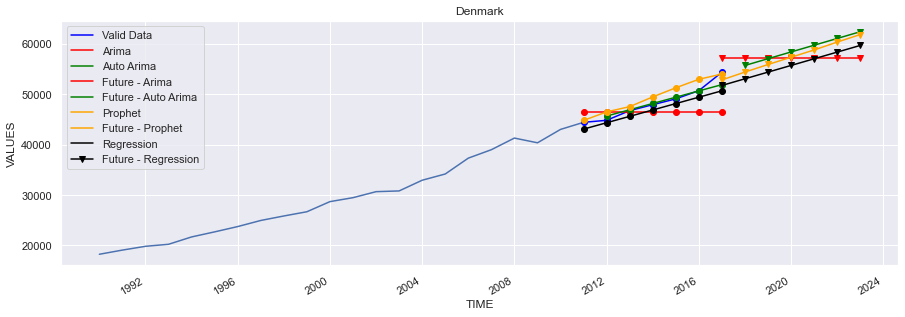

In [32]:
# Step 5 - Testing it on all countries

# creating a country list
countries = forecast_data['COUNTRY'].unique()

# Denmark gives an error

countries = ['Denmark']

for c in countries:
    # filtering the train data
    print(c)
    train_data = X_train[X_train['COUNTRY'] == c]
    train_data2 = train_data[['TIME', 'VALUES']]
    
    # filtering the valid data
    valid_data = X_valid[X_valid['COUNTRY'] == c]
    valid_data2 = valid_data[['TIME', 'VALUES']]
    
    # all data
    all_data = forecast_data[forecast_data['COUNTRY']==c]
    all_data2 = all_data[['TIME', 'VALUES']]
    
    #convert date column to datetime
    train_data2.set_index('TIME', inplace=True)
    valid_data2.set_index('TIME', inplace=True)
    valid_data2.columns = ['Valid Data']    
    all_data2.set_index('TIME', inplace=True)
    

    # Setting the Valid - Index for 6 years
    index_7_years = pd.date_range(train_data2.index[-1], freq='AS', periods = 7) 
    
    # Setting the Future - Index for 6 years
    future_index_7_years = pd.date_range(valid_data2.index[-1], freq='AS', periods = 7) 
    
    # Dropping all tables
    try:
        del t_fcast1
        del t_fcast2
        del t_fcast3
        del t_fcast4
        
        del f_fcast1
        del f_fcast2
        del f_fcast3 
        del f_fcast4
        
    except:
        print("")

    try:
        del df_fcast1
        del df_fcast2
        del df_fcast3
        del df_fcast4
    except:
        print("")
        
    ##############################################################################################################
    ######################################            ARIMA             ##########################################  
    ##############################################################################################################
    
     # THIS IS FOR THE VALIDATION PHASE 
    #try:        
    try:
        # Running ARIMA on Best parameter
        model_arima = sm.tsa.arima.ARIMA(train_data2, order=(0,2,3))
        model_arima_fit = model_arima.fit()

        # Saving ARIMA predictions
        t_fcast1 = model_arima_fit.forecast(7)[0]
        # Passing the same index as the others
        t_fcast1 = pd.Series(t_fcast1, index=index_7_years)
        t_fcast1 = t_fcast1.rename("Arima") 
    except:
        # Running ARIMA on Best parameter
        model_arima = sm.tsa.arima.ARIMA(train_data2, order=(4,1,1))
        model_arima_fit = model_arima.fit()

        # Saving ARIMA predictions
        t_fcast1 = model_arima_fit.forecast(7)[0]
        # Passing the same index as the others
        t_fcast1 = pd.Series(t_fcast1, index=index_7_years)
        t_fcast1 = t_fcast1.rename("Arima") 
    #except:
        #print(c, "Arima Train Error")
        
     # THIS IS FOR THE FUTURE PHASE
    #try:        
    try:
        # Running ARIMA on Best parameter
        model_arima = sm.tsa.arima.ARIMA(all_data2, order=(0,2,3))
        model_arima_fit = model_arima.fit()

        # Saving ARIMA predictions
        f_fcast1 = model_arima_fit.forecast(7)[0]
        # Passing the same index as the others
        f_fcast1 = pd.Series(f_fcast1, index=future_index_7_years)
        f_fcast1 = f_fcast1.rename("Future - Arima") 
    except:
        # Running ARIMA on Best parameter
        model_arima = sm.tsa.arima.ARIMA(all_data2, order=(4,1,0))
        model_arima_fit = model_arima.fit(disp=-1)

        # Saving ARIMA predictions
        f_fcast1 = model_arima_fit.forecast(7)[0]
        # Passing the same index as the others
        f_fcast1 = pd.Series(f_fcast1, index=future_index_7_years)
        f_fcast1 = f_fcast1.rename("Future - Arima") 
    #except:
        #print(c, "Arima Future Error")  
        
    ##############################################################################################################
    ######################################      AUTO - ARIMA             ######################################### 
    ##############################################################################################################
    
   # THIS IS FOR THE VALIDATION PHASE
    #try:
    # Running auto ARIMA 
    auto_arima_model = pm.auto_arima(train_data2, seasonal=False, m=7)

    # make your forecasts
    t_fcast2 = auto_arima_model.predict(7) 
    t_fcast2 = pd.Series(t_fcast2, index=index_7_years)
    t_fcast2 = t_fcast2.rename("Auto Arima")

    #except:
        #print(c, "Auto Arima Train Error") 
        
     # THIS IS FOR THE FUTURE PHASE
    #try:
        # Running auto ARIMA Future
    auto_arima_model = pm.auto_arima(all_data2, seasonal=False, m=7)

    # make your forecasts
    f_fcast2 = auto_arima_model.predict(7) 
    f_fcast2 = pd.Series(f_fcast2, index=future_index_7_years)
    f_fcast2 = f_fcast2.rename("Future - Auto Arima")

    #except:
        #print(c, "Auto Arima Future Error") 

    ##############################################################################################################
    ######################################      PROPHET             ############################################## 
    ##############################################################################################################
    
    # prepare expected column names
    train_data3 = train_data.copy()
    train_data3 = train_data3[['TIME', 'VALUES']]
    train_data3.columns = ['ds', 'y']
    train_data3['ds']= to_datetime(train_data3['ds'])
    
    all_data3 = all_data.copy()
    all_data3 = all_data3[['TIME', 'VALUES']]
    all_data3.columns = ['ds', 'y']
    all_data3['ds']= to_datetime(all_data3['ds'])

    # define the period for which we want a prediction - Valid
    v_df_index_7_years = pd.DataFrame(index_7_years)
    v_df_index_7_years.columns = ['ds']
    v_df_index_7_years['ds']= to_datetime(v_df_index_7_years['ds'])

    # define the period for which we want a prediction - Future
    f_df_index_7_years = pd.DataFrame(future_index_7_years)
    f_df_index_7_years.columns = ['ds']
    f_df_index_7_years['ds']= to_datetime(f_df_index_7_years['ds'])
    
    ############### THIS IS FOR THE VALIDATION PHASE  ##################

    # define the model
    model = Prophet()
    # fit the model
    model.fit(train_data3)

    # use the model to make a forecast
    t_fcast3 = model.predict(v_df_index_7_years)
    t_fcast3 = pd.Series(t_fcast3['yhat'].values, index=index_7_years)
    t_fcast3 = t_fcast3.rename("Prophet")
    
    ############### THIS IS FOR THE VALIDATION PHASE  ##################

    # define the model
    model2 = Prophet()
    # fit the model
    model2.fit(all_data3)

    # use the model to make a forecast
    f_fcast3 = model2.predict(f_df_index_7_years)
    f_fcast3 = pd.Series(f_fcast3['yhat'].values, index=future_index_7_years)
    f_fcast3 = f_fcast3.rename("Future - Prophet")  

    ##############################################################################################################
    ########################################         Regression         ##########################################
    ##############################################################################################################
    
    # Creating Ordinal Dates
    train_data['MonthNumberOrdinal'] = train_data['TIME']
    train_data['MonthNumberOrdinal'] = pd.to_datetime(train_data['MonthNumberOrdinal']).map(datetime.toordinal)

    all_data['MonthNumberOrdinal'] = all_data['TIME']
    all_data['MonthNumberOrdinal'] = pd.to_datetime(all_data['MonthNumberOrdinal']).map(datetime.toordinal)

    # adding the ordinal dates to the prediction dates
    v_df_index_7_years['ForecastDate_Ordinal'] = pd.to_datetime(v_df_index_7_years['ds']).map(datetime.toordinal)
    f_df_index_7_years['ForecastDate_Ordinal'] = pd.to_datetime(f_df_index_7_years['ds']).map(datetime.toordinal)


    # Fitting LR on Valid
    reg = linear_model.LinearRegression()
    reg.fit(train_data['MonthNumberOrdinal'].values.reshape(-1, 1), train_data['VALUES'].values)

    # Making predictions
    t_fcast4 = reg.predict(v_df_index_7_years['ForecastDate_Ordinal'].values.reshape(-1, 1))

    # Passing the same index as the others
    t_fcast4 = pd.Series(t_fcast4, index=index_7_years)
    t_fcast4 = t_fcast4.rename("Regression")

    # Fitting LR on Future
    reg2 = linear_model.LinearRegression()
    reg2.fit(all_data['MonthNumberOrdinal'].values.reshape(-1, 1), all_data['VALUES'].values)

    # Making predictions
    f_fcast4 = reg2.predict(f_df_index_7_years['ForecastDate_Ordinal'].values.reshape(-1, 1))

    # Passing the same index as the others
    f_fcast4 = pd.Series(f_fcast4, index=future_index_7_years)
    f_fcast4 = f_fcast4.rename("Future - Regression")
    
    ##############################################################################################################
    ########################################      SAVING THE MSE        ##########################################
    ##############################################################################################################
    
    t_fcast1_mse = mean_squared_error(valid_data['VALUES'].values, t_fcast1.values, squared=False)
    t_fcast2_mse = mean_squared_error(valid_data['VALUES'].values, t_fcast1.values, squared=False)
    t_fcast3_mse = mean_squared_error(valid_data['VALUES'].values, t_fcast3.values, squared=False)
    t_fcast4_mse = mean_squared_error(valid_data['VALUES'].values, t_fcast4.values, squared=False)
    
    ##############################################################################################################
    ########################################      PLOTTING              ##########################################
    ##############################################################################################################
    
    fig, ax = plt.subplots(figsize=(15,5))
    chart = sns.lineplot(x='TIME', y='VALUES', data = train_data)
    chart.set_title(c)
    valid_data2.plot(ax=ax, color='blue', marker="o", legend=True)
    # ploting validation
    try:
        t_fcast1.plot(ax=ax, color='red', marker="o", legend=True)
    except:
        print("")        
    try:
        t_fcast2.plot(ax=ax, color='green', marker="o", legend=True)
    except:
        print("")
        
    # plotting future
    try:
        f_fcast1.plot(ax=ax, color='red', marker="v", legend=True)
    except:
        print("")        
    try:
        f_fcast2.plot(ax=ax, color='green', marker="v", legend=True)
    except:
        print("") 
    
    t_fcast3.plot(ax=ax, color='orange', marker="o", legend=True)
    f_fcast3.plot(ax=ax, color='orange', marker="v", legend=True)
    
    t_fcast4.plot(ax=ax, color='black', marker="o", legend=True)
    f_fcast4.plot(ax=ax, color='black', marker="v", legend=True)  
        
    ##############################################################################################################
    ########################################      SAVING THE RESULTS     #########################################
    ##############################################################################################################
    
    try:
        # Creating a DF for fcast1
        t_fcast1 = t_fcast1.reset_index()
        t_fcast1.columns = ['Date','Arima ForecastValue Validation']

        f_fcast1 = f_fcast1.reset_index()
        f_fcast1.columns = ['Date','Arima ForecastValue Future']

        # Creating the extra columns
        t_fcast1['Arima ForecastValue Future'] = np.nan
        f_fcast1['Arima ForecastValue Validation'] = np.nan

        # reordering 1 only
        t_fcast1 = t_fcast1[['Date','Arima ForecastValue Future','Arima ForecastValue Validation']]

        # Joining them together
        df_fcast1 = pd.concat([t_fcast1, f_fcast1], axis=0)
        df_fcast1['Country'] = c
        df_fcast1['ML Method'] = 'Arima'
        df_fcast1['Arima MSE'] = t_fcast1_mse
    
    except:
        df_fcast1 = pd.DataFrame({'Date': [np.nan], 'Arima ForecastValue Future': [np.nan],'Arima ForecastValue Validation': [np.nan], 'Country':[c], 'ML Method':['Arima']})

    try:
        # Creating a DF for fcast2
        t_fcast2 = t_fcast2.reset_index()
        t_fcast2.columns = ['Date','Auto-Arima ForecastValue Validation']

        f_fcast2 = f_fcast2.reset_index()
        f_fcast2.columns = ['Date','Auto-Arima ForecastValue Future']

        # Creating the extra columns
        t_fcast2['Auto-Arima ForecastValue Future'] = np.nan
        f_fcast2['Auto-Arima ForecastValue Validation'] = np.nan

        # reordering 1 only
        t_fcast2 = t_fcast2[['Date','Auto-Arima ForecastValue Future','Auto-Arima ForecastValue Validation']]

        # Joining them together
        df_fcast2 = pd.concat([t_fcast2, f_fcast2], axis=0)
        df_fcast2['Country'] = c
        df_fcast2['ML Method'] = 'Auto-Arima'
        df_fcast2['Auto-Arima MSE'] = t_fcast2_mse
    
    except:
        df_fcast2 = pd.DataFrame({'Date': [np.nan], 'Auto-Arima ForecastValue Future': [np.nan],'Auto-Arima ForecastValue Validation': [np.nan], 'Country':[c], 'ML Method':['Auto-Arima']})
        
    try:
        # Creating a DF for fcast3
        t_fcast3 = t_fcast3.reset_index()
        t_fcast3.columns = ['Date','Prophet ForecastValue Validation']

        f_fcast3 = f_fcast3.reset_index()
        f_fcast3.columns = ['Date','Prophet ForecastValue Future']

        # Creating the extra columns
        t_fcast3['Prophet ForecastValue Future'] = np.nan
        f_fcast3['Prophet ForecastValue Validation'] = np.nan

        # reordering 1 only
        t_fcast3 = t_fcast3[['Date','Prophet ForecastValue Future','Prophet ForecastValue Validation']]

        # Joining them together
        df_fcast3 = pd.concat([t_fcast3, f_fcast3], axis=0)
        df_fcast3['Country'] = c
        df_fcast3['ML Method'] = 'Prophet'
        df_fcast3['Prophet MSE'] = t_fcast3_mse
    
    except:
        df_fcast3 = pd.DataFrame({'Date': [np.nan], 'Prophet ForecastValue Future': [np.nan],'Prophet ForecastValue Validation': [np.nan], 'Country':[c], 'ML Method':['Auto-Arima']})
        
    try:
        # Creating a DF for fcast4
        t_fcast4 = t_fcast4.reset_index()
        t_fcast4.columns = ['Date','Regression ForecastValue Validation']

        f_fcast4 = f_fcast4.reset_index()
        f_fcast4.columns = ['Date','Regression ForecastValue Future']

        # Creating the extra columns
        t_fcast4['Regression ForecastValue Future'] = np.nan
        f_fcast4['Regression ForecastValue Validation'] = np.nan

        # reordering 1 only
        t_fcast4 = t_fcast4[['Date','Regression ForecastValue Future','Regression ForecastValue Validation']]

        # Joining them together
        df_fcast4 = pd.concat([t_fcast4, f_fcast4], axis=0)
        df_fcast4['Country'] = c
        df_fcast4['ML Method'] = 'Regression'
        df_fcast4['Regression MSE'] = t_fcast4_mse
        df_fcast4['Regression Slope'] = reg2.coef_[0]
        df_fcast4['Regression Trend Direction'] = np.where(df_fcast4['Regression Slope']<=0, 'Negative Trend', 'Positive Trend')
        df_fcast4['Regression Slope Monthly Change Proj'] = df_fcast4['Regression ForecastValue Future'].iloc[-1] - df_fcast4['Regression ForecastValue Future'].iloc[-2]
    
    except:
        df_fcast4 = pd.DataFrame({'Date': [np.nan], 'Regression ForecastValue Future': [np.nan],'Regression ForecastValue Validation': [np.nan], 'Country':[c], 'ML Method':['Auto-Arima'], 'Regression Slope':[np.nan], 'Regression Trend Direction':[np.nan], 'Regression Slope Monthly Change Proj':[np.nan]})
        
    # Aggregating the data to avoid duplication
    df_fcast1 = df_fcast1.groupby(['Date', 'Country','ML Method'], as_index = False).agg({'Arima ForecastValue Future':'sum','Arima ForecastValue Validation':'sum','Arima MSE':'max'})
    df_fcast2 = df_fcast2.groupby(['Date', 'Country','ML Method'], as_index = False).agg({'Auto-Arima ForecastValue Future':'sum','Auto-Arima ForecastValue Validation':'sum','Auto-Arima MSE':'max'})
    df_fcast3 = df_fcast3.groupby(['Date', 'Country','ML Method'], as_index = False).agg({'Prophet ForecastValue Future':'sum','Prophet ForecastValue Validation':'sum','Prophet MSE':'max'})
    df_fcast4 = df_fcast4.groupby(['Date', 'Country','ML Method', 'Regression Trend Direction'], as_index = False).agg({'Regression ForecastValue Future':'sum','Regression ForecastValue Validation':'sum','Regression MSE':'max','Regression Slope':'max','Regression Slope Monthly Change Proj':'max'})

    # joining them all together
    all_forecasts = df_fcast1.merge(df_fcast2[['Date','Auto-Arima ForecastValue Future','Auto-Arima ForecastValue Validation', 'Auto-Arima MSE']], how = 'left', on ='Date')
    all_forecasts = all_forecasts.merge(df_fcast3[['Date','Prophet ForecastValue Future', 'Prophet ForecastValue Validation', 'Prophet MSE']], how = 'left', on ='Date')
    all_forecasts = all_forecasts.merge(df_fcast4[['Date','Regression ForecastValue Future', 'Regression ForecastValue Validation', 'Regression MSE', 'Regression Slope','Regression Slope Monthly Change Proj','Regression Trend Direction']], how = 'left', on ='Date')

    # Saving the predictions in a DF
    try:
        final_forecasts = pd.concat([final_forecasts, all_forecasts], ignore_index = True)
    except:
        final_forecasts = all_forecasts    

In [33]:
#t_fcast1_mse = mean_squared_error(valid_data['value'].values, t_fcast1.values, squared=False)

t_fcast1

,Date,Arima ForecastValue Future,Arima ForecastValue Validation
0,2011-01-01,NaN,46457.282677
1,2012-01-01,NaN,46457.282677
2,2013-01-01,NaN,46457.282677
3,2014-01-01,NaN,46457.282677
4,2015-01-01,NaN,46457.282677
5,2016-01-01,NaN,46457.282677
6,2017-01-01,NaN,46457.282677


In [34]:
# Union-ing predictions with the original dataset 

#creating the needed columns
forecast_data['Arima ForecastValue Future'] = np.nan
forecast_data['Arima ForecastValue Validation'] = np.nan
forecast_data['Arima MSE'] = np.nan
forecast_data['Auto-Arima ForecastValue Future'] = np.nan
forecast_data['Auto-Arima ForecastValue Validation'] = np.nan
forecast_data['Auto-Arima MSE'] = np.nan
forecast_data['Prophet ForecastValue Future'] = np.nan
forecast_data['Prophet ForecastValue Validation'] = np.nan
forecast_data['Prophet MSE'] = np.nan
forecast_data['Regression ForecastValue Future'] = np.nan
forecast_data['Regression ForecastValue Validation'] = np.nan
forecast_data['Regression MSE'] = np.nan
forecast_data['Regression Slope'] = np.nan
forecast_data['Regression Slope Monthly Change Proj'] = np.nan
forecast_data['Regression Trend Direction'] = np.nan

forecast_data = forecast_data.rename({'TIME': 'Date', 'COUNTRY':'Country'}, axis=1)

del final_forecasts['ML Method']

final_forecasts['VALUES'] = np.nan



In [36]:

# Reordering final_forecasts

final_forecasts = final_forecasts[['Country', 'Date', 'VALUES', 'Arima ForecastValue Future',
       'Arima ForecastValue Validation', 'Arima MSE',
       'Auto-Arima ForecastValue Future',
       'Auto-Arima ForecastValue Validation', 'Auto-Arima MSE',
       'Prophet ForecastValue Future', 'Prophet ForecastValue Validation',
       'Prophet MSE', 'Regression ForecastValue Future',
       'Regression ForecastValue Validation', 'Regression MSE',
       'Regression Slope', 'Regression Slope Monthly Change Proj',
       'Regression Trend Direction']]

# Union
output_df = pd.concat([forecast_data, final_forecasts], axis=0)

In [37]:
output_df.tail()

,Country,Date,VALUES,Arima ForecastValue Future,Arima ForecastValue Validation,Arima MSE,Auto-Arima ForecastValue Future,Auto-Arima ForecastValue Validation,Auto-Arima MSE,Prophet ForecastValue Future,Prophet ForecastValue Validation,Prophet MSE,Regression ForecastValue Future,Regression ForecastValue Validation,Regression MSE,Regression Slope,Regression Slope Monthly Change Proj,Regression Trend Direction
60,Denmark,2019-01-01,NaN,57111.148815,0.0,3707.613719,57033.556667,0.0,3707.613719,55881.868842,0.0,1512.232294,54371.769516,0.0,1717.22427,3.62308,1322.424339,Positive Trend
61,Denmark,2020-01-01,NaN,57111.148815,0.0,3707.613719,58372.110000,0.0,3707.613719,57319.591643,0.0,1512.232294,55694.193855,0.0,1717.22427,3.62308,1322.424339,Positive Trend
62,Denmark,2021-01-01,NaN,57111.148815,0.0,3707.613719,59710.663333,0.0,3707.613719,58774.209815,0.0,1512.232294,57020.241274,0.0,1717.22427,3.62308,1322.424339,Positive Trend
63,Denmark,2022-01-01,NaN,57111.148815,0.0,3707.613719,61049.216667,0.0,3707.613719,60332.170533,0.0,1512.232294,58342.665613,0.0,1717.22427,3.62308,1322.424339,Positive Trend
64,Denmark,2023-01-01,NaN,57111.148815,0.0,3707.613719,62387.770000,0.0,3707.613719,61829.810544,0.0,1512.232294,59665.089952,0.0,1717.22427,3.62308,1322.424339,Positive Trend


In [38]:
# Setting zeros to np.nan for Power BI

output_df['Arima ForecastValue Future'][output_df['Arima ForecastValue Future'] < 1] = np.nan
output_df['Arima ForecastValue Validation'][output_df['Arima ForecastValue Validation'] < 1] = np.nan
output_df['Arima MSE'][output_df['Arima MSE'] < 1] = np.nan
output_df['Auto-Arima ForecastValue Future'][output_df['Auto-Arima ForecastValue Future'] < 1] = np.nan
output_df['Auto-Arima ForecastValue Validation'][output_df['Auto-Arima ForecastValue Validation'] < 1] = np.nan
output_df['Auto-Arima MSE'][output_df['Auto-Arima MSE'] < 1] = np.nan
output_df['Prophet ForecastValue Future'][output_df['Prophet ForecastValue Future'] < 1] = np.nan
output_df['Prophet ForecastValue Validation'][output_df['Prophet ForecastValue Validation'] < 1] = np.nan
output_df['Prophet MSE'][output_df['Prophet MSE'] < 1] = np.nan
output_df['Regression ForecastValue Future'][output_df['Regression ForecastValue Future'] < 1] = np.nan
output_df['Regression ForecastValue Validation'][output_df['Regression ForecastValue Validation'] < 1] = np.nan
output_df['Regression MSE'][output_df['Regression MSE'] < 1] = np.nan
output_df['Regression Slope'][output_df['Regression Slope'] < 1] = np.nan
output_df['Regression Slope Monthly Change Proj'][output_df['Regression Slope Monthly Change Proj'] < 1] = np.nan
#output_df['Regression Trend Direction'][output_df['Regression Trend Direction'] < 1] = np.nan

### Exporting/Writing data to CSV

In [39]:
# Exporting the data in a CSV
output_df.to_csv('Time Series Forecast GDP', sep='\t')

os. getcwd() 

'C:\\Users\\kothai\\Desktop'